# Group JABS 

### Big Data Final Project

*Note that initiall code uses python due to package requirement (the package provided by the data source is in python, so our initial work is in python. After we have collected the data into our final dataframe, we switch to spark for model building and analysis)

# __Table of Contents__
1) Pulling in the data  
2) Importing needed packages  
3) Loading and Reading the data  
4) Data Exploration (Part 1) - Initial  
5) Feature Engineering  
6) Converting data to from Python to Spark  
7) Data Exploration (Part 2) - Data Cleaning / Checking for Outliers  
8) Descriptive Statistics  
9) Feature Vector Creation  
10) Correlation Visualization  
11) Feature Vector Scaling  
12) Split into Train/Test  
13) Initial Model Exploration  

*Note: please see second jupyter notebook for pipeline and robust model creation/exploration  
*Note: please see third jupyter notebook for future work with neural network  

# Pulling in the data

Data made available through Phsionet: https://physionet.org/content/ptb-xl/1.0.1/

First we extract the available data file from the zip folder

In [1]:
# import zipfile

In [2]:
# with zipfile.ZipFile("ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.1.zip", "r") as zip_ref:


# Import

We will also use a speacial "wfdb" package to view the data from Physionet

In [3]:
import wfdb
import pandas as pd
import numpy as np
import ast
import pyspark.sql.functions as F
from pyspark.sql.functions import col,sum, isnan
from scipy.signal import find_peaks
from scipy import sparse
from scipy.sparse.linalg import spsolve
import matplotlib.pyplot as plt 
import biosppy
from biosppy.signals import ecg


# Load and Read in the Data

We have three main datasets of interest. The first (which we label "Y" below) is metadata collected about the patients, how the ECG test was performed, and the results of the test. We also have two datasets about the ECG data collected from the 12 leads. One dataset is sampled at 500Hz, while the second is sampled at 100Hz. For our purposed, we will use the 100Hz dataset for this report (labelled as "X" below)

From the outputs below, we find that the metadata has 21837 ECG tests performed, which is matched by the "ECG-lead" data. The metadata also has 27 columns of information for each observation. The "ECG-lead" data also has 1000 data points for each test (100Hz sapling for 10 seconds) across the 12 leads used in the data collection.

In [4]:
def load_raw_data(df, sampling_rate, path):
    if sampling_rate == 100:
        data = [wfdb.rdsamp(path+f) for f in df.filename_lr]
    else:
        data = [wfdb.rdsamp(path+f) for f in df.filename_hr]
    data = np.array([signal for signal, meta in data])
    return data

In [5]:
# from physionet
# Binyong's path
# path = "data/"
# # XXX's path
path = "ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.1/"
sampling_rate=100

In [40]:
Y = pd.read_csv(path+'ptbxl_database.csv', index_col='ecg_id')
Y.scp_codes = Y.scp_codes.apply(lambda x: ast.literal_eval(x))

In [7]:
X = load_raw_data(Y, sampling_rate, path)

In [7]:
Y.shape

(21837, 27)

In [8]:
X.shape

(21837, 1000, 12)

In [10]:
len(X[0].sum(axis=1))

1000

# Data Exploration

First we explore some of the metadata (we will perform more data exploration after feature engineering)

We find the percentage of missing values by column, based on what data is available, as well as what data is useful for the model, we will use the columns "age" and "sex" to construct the model

In [44]:
Y.isna().sum(axis = 0)/21837*100

patient_id                       0.000000
age                              0.407565
sex                              0.000000
height                          68.022164
weight                          56.820992
nurse                            6.910290
site                             0.082429
device                           0.000000
recording_date                   0.000000
report                           0.000000
scp_codes                        0.000000
heart_axis                      38.947658
infarction_stadium1             74.236388
infarction_stadium2             99.528323
validated_by                    43.096579
second_opinion                   0.000000
initial_autogenerated_report     0.000000
validated_by_human               0.000000
baseline_drift                  92.640931
static_noise                    85.062051
burst_noise                     97.192838
electrodes_problems             99.862618
extra_beats                     91.051884
pacemaker                       98

## We explore the ECG data and run some stats on it
## We will revisit data exploration and statistics after we have performed feature engineering (later exploration will include stats run on both the metadata and the newly added features)

First we generate an appendix with all the ECG data for review

In [ ]:
for i in range(0, len(X)):
    plot = wfdb.plot_items(X[i], figsize=(24,20), title = "Patient {}".format(i), return_fig = True)
    plot.savefig("Patient {}.pdf".format(i))
    plt.close(plot)

In [30]:
print("The number of records of ECG data is " + str(len(X)))
print("Which matches the number of records from teh demographics data: " + str(len(Y)))

The number of records of ECG data is 21837
Which matches the number of records from teh demographics data: 21837


In [31]:
for record in range(0,len(X)):
    if len(X[record]) != 1000:
        print("there was a record that didn't have exactly 1000 observations")
print("Each record had exactly " + str(len(X[1])) +" observations")


Each record had exactly 1000 observations


In [32]:
for record in range(0,len(X)):
    if len(X[record]) != 1000:
        print("there was a record that didn't have exactly 1000 observations")
print("Each observation had exactly " + str(len(X[1][1])) +" measurements (for the 12 leads)")

Each observation had exactly 12 measurements (for the 12 leads)


In [33]:
import matplotlib.pyplot as plt 
plot_testX = range(0,1000)

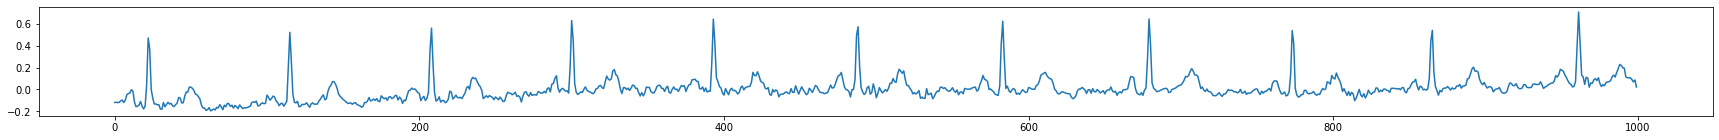

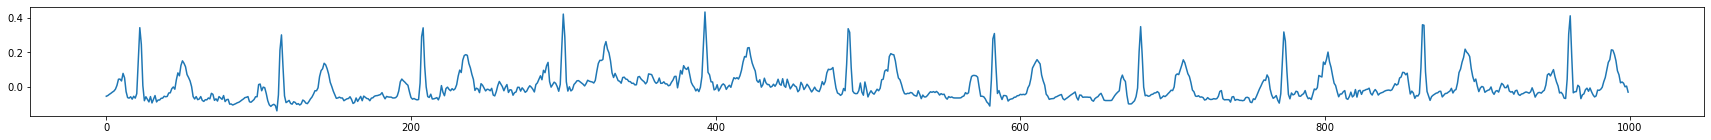

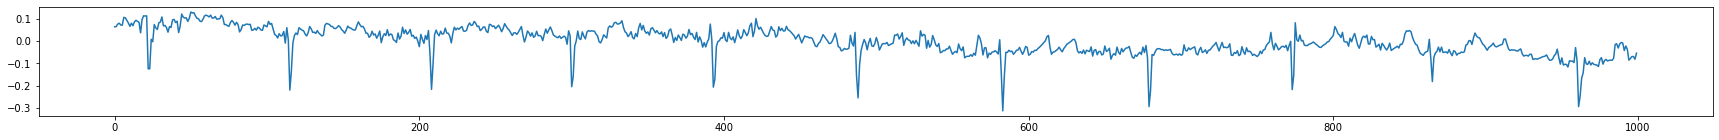

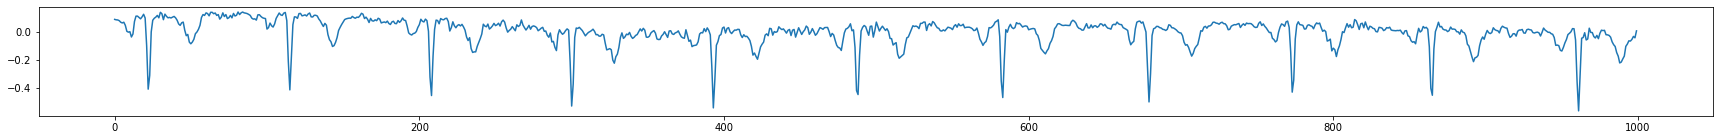

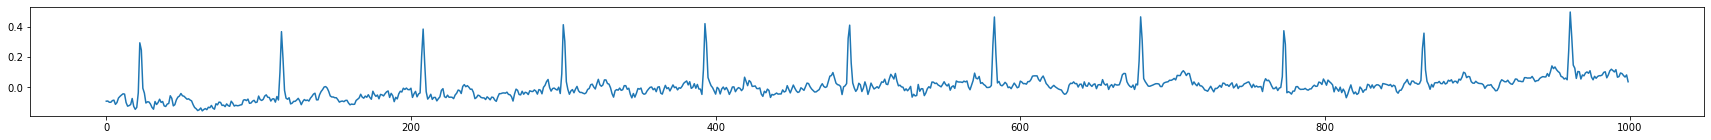

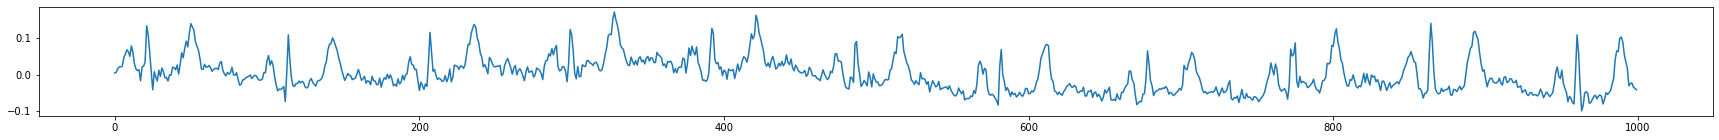

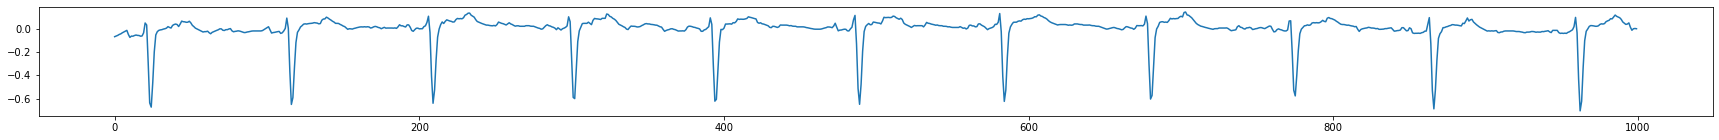

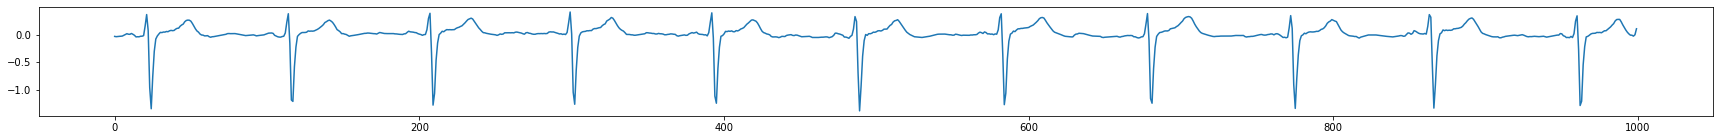

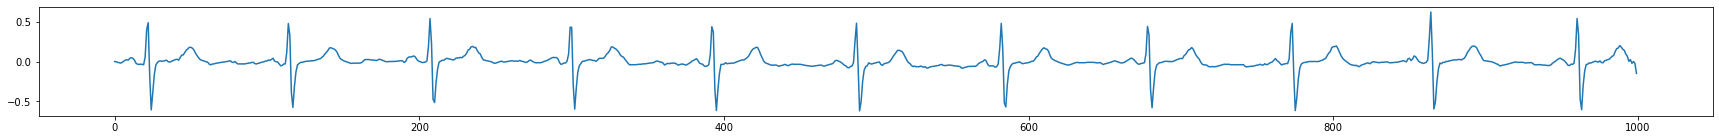

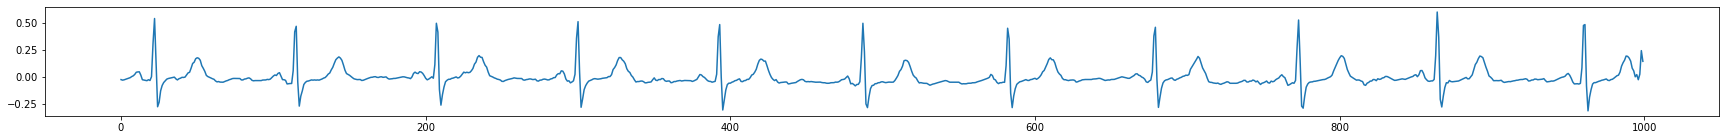

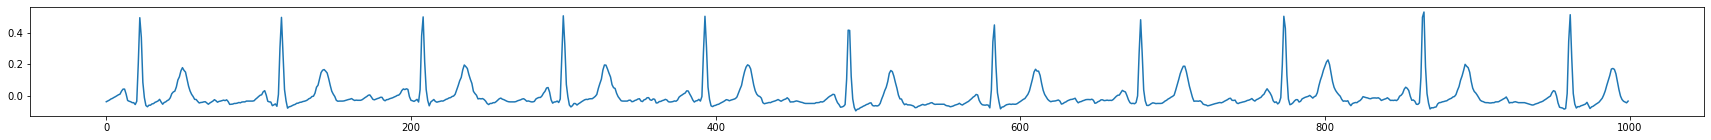

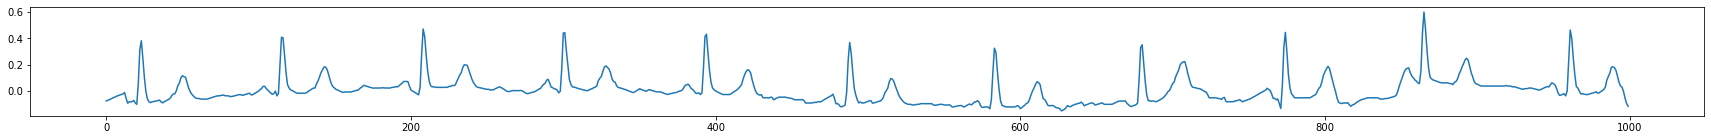

In [34]:
def getPlotableMeasurements(ecg_id, lead):
    array = [0]*1000
    for x in range(0,1000):
        array[x] = X[ecg_id][x][lead]
    return(array)
        
leadI = getPlotableMeasurements(0,0)
leadII = getPlotableMeasurements(0,1)
leadIII =  getPlotableMeasurements(0,2)
leadAVR = getPlotableMeasurements(0,3)
leadAVL = getPlotableMeasurements(0,4)
leadAVF = getPlotableMeasurements(0,5)
leadV1 = getPlotableMeasurements(0,6)
leadV2 = getPlotableMeasurements(0,7)
leadV3 = getPlotableMeasurements(0,8)
leadV4 = getPlotableMeasurements(0,9)
leadV5 = getPlotableMeasurements(0,10)
leadV6 = getPlotableMeasurements(0,11)
plt.figure(figsize=(30,2))
plt.plot(plot_testX, leadI, label = "line 1")
plt.figure(figsize=(30,2))
plt.plot(plot_testX, leadII, label = "line 1")
plt.figure(figsize=(30,2))
plt.plot(plot_testX, leadIII, label = "line 1")
plt.figure(figsize=(30,2))
plt.plot(plot_testX, leadAVR, label = "line 1")
plt.figure(figsize=(30,2))
plt.plot(plot_testX, leadAVL, label = "line 1")
plt.figure(figsize=(30,2))
plt.plot(plot_testX, leadAVF, label = "line 1")
plt.figure(figsize=(30,2))
plt.plot(plot_testX, leadV1, label = "line 1")
plt.figure(figsize=(30,2))
plt.plot(plot_testX, leadV2, label = "line 1")
plt.figure(figsize=(30,2))
plt.plot(plot_testX, leadV3, label = "line 1")
plt.figure(figsize=(30,2))
plt.plot(plot_testX, leadV4, label = "line 1")
plt.figure(figsize=(30,2))
plt.plot(plot_testX, leadV5, label = "line 1")
plt.figure(figsize=(30,2))
plt.plot(plot_testX, leadV6, label = "line 1")

# Feature Engineering

## Heart rate and R peak
#### Some of the first features we will need to calcualte from the ECG data is the location of the R peaks (from which we can then calucate the heart rate, and other clinically relevant features) 

#### This will require filtering noise in the data, as well as properly accounting for where the R peaks occur. After much exploration, we have decided to use the BioSPPY package to accomplish this task.

#### Below we demonstrate the effectiveness of this package as well as how the package handles specific edge cases in the ECG data

#### After exploring the ECG data, we found many edge cases that we want to make sure we account for in our filtering and R peak estimations. We present some of those edge cases below and demonstrate that the BioSPPY package correctly handles those cases

#### Note that we would expect the ECG data to resemble the image below, but the edge cases we will present will not resemble the image due to their edge case
(PQRST Complex Wave [5]., n.d.)
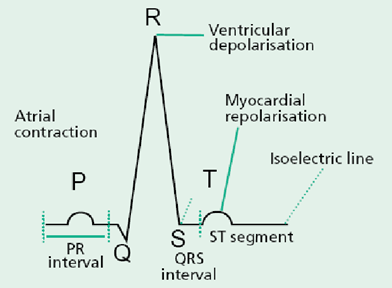

In [9]:
def getPlotableMeasurements(ecg_id, lead):
    array = [0]*1000
    for x in range(0,1000):
        array[x] = X[ecg_id][x][lead]
    return(array)

In [10]:
def checkBioSPPYOutput(ecg_id, lead):
    plot_testX = range(0,1000)
    test_signal = getPlotableMeasurements(ecg_id, lead)
    out = ecg.ecg(signal=test_signal, sampling_rate=100, show=True)
    # rpeaks
    print("Rpeaks")
    print(out[2])
    #heart rate
    print("heart rate")
    print(out[6])
    # returns R peak indices
    print(biosppy.signals.ecg.christov_segmenter(signal=test_signal,sampling_rate=100))
    plt.figure(figsize=(30,2))
    plt.plot(plot_testX, test_signal, label = "line 1")
    plt.figure(figsize=(30,2))
    plt.plot(plot_testX, out[1], label = "line 1")
    plt.scatter(out[2], [out[1][out[2][0]]]*len(out[2]), label = "x", color = "red")

### __Regular ECG__

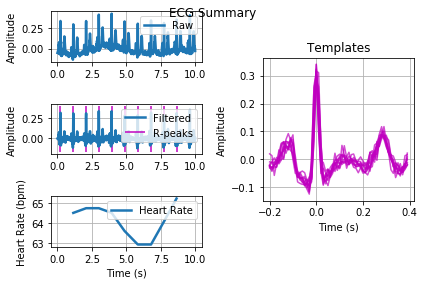

Rpeaks
[ 22 115 208 300 393 487 583 679 773 864]
heart rate
[64.51612903 64.74988312 64.74988312 64.52110252 63.61530542 62.94326241
 62.94326241 64.08795106 65.2326397 ]
ReturnTuple(rpeaks=array([ 22, 115, 208, 300, 393, 487, 583, 679, 773, 864, 961]))


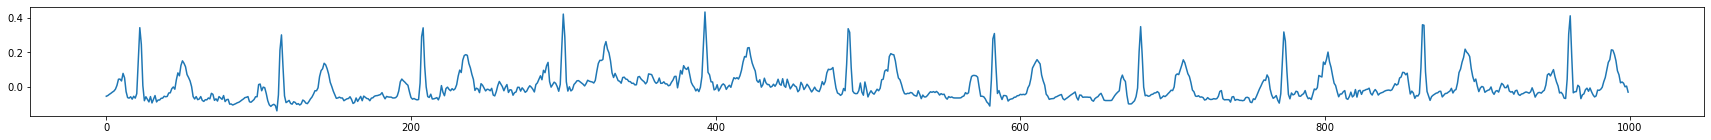

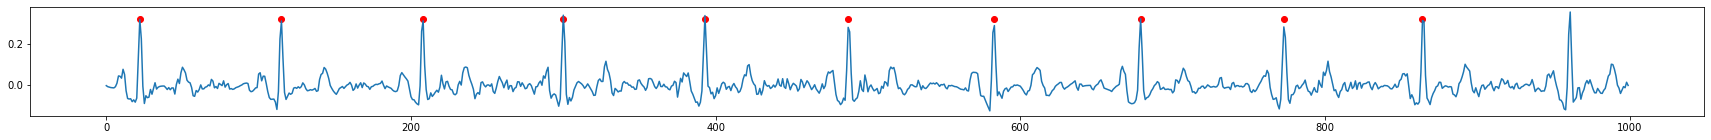

In [13]:
checkBioSPPYOutput(0,1)

### __Noisy ECG__ (Noise Likely from Power Input - overall plot is sinusoidal)

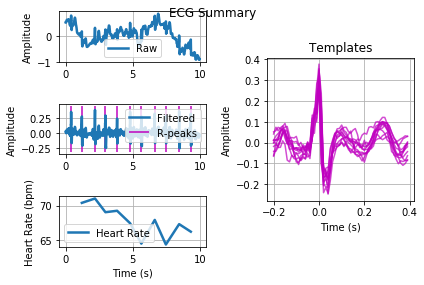

Rpeaks
[ 41 121 219 297 384 481 565 665 748 847 934]
heart rate
[70.40816327 71.04918891 69.03769465 69.24808809 67.41658626 64.42808051
 67.90590935 64.29840574 67.28691149 66.1790317 ]
ReturnTuple(rpeaks=array([ 41, 121, 219, 297, 384, 481, 575, 665, 748, 847, 934]))


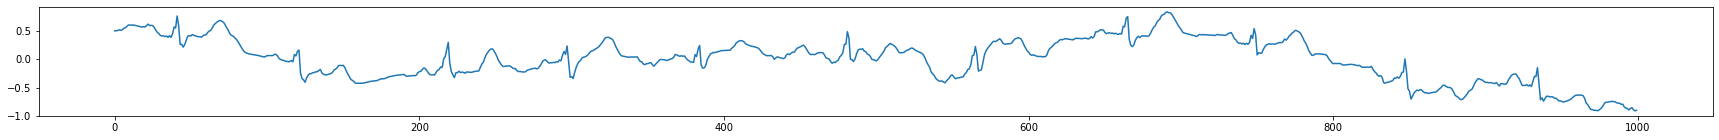

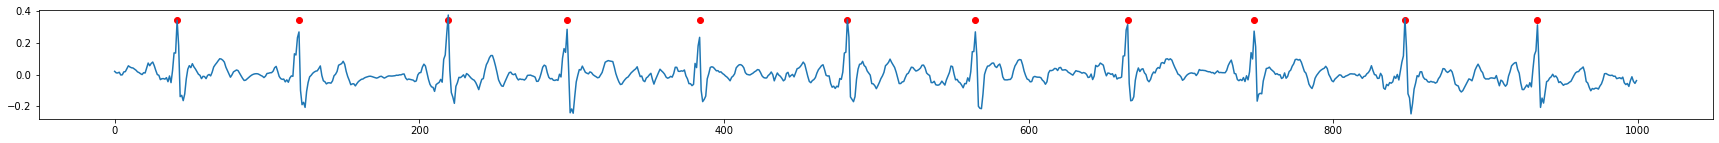

In [14]:
checkBioSPPYOutput(49,1)

### __ECG with Relatively low Amplitude R peak__

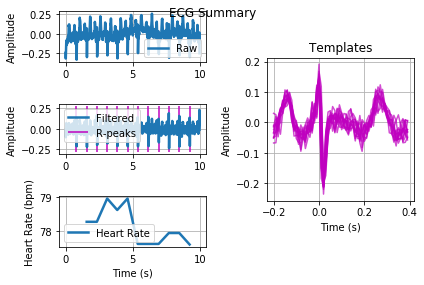

Rpeaks
[ 80 157 233 310 385 462 538 617 694 770 848 925]
heart rate
[78.26384142 78.26384142 78.95648211 78.61471861 78.95648211 77.60627114
 77.60627114 77.60627114 77.93084109 77.93084109 77.58907759]
ReturnTuple(rpeaks=array([ 80, 157, 233, 310, 385, 462, 538, 617, 694, 770, 848, 925, 986]))


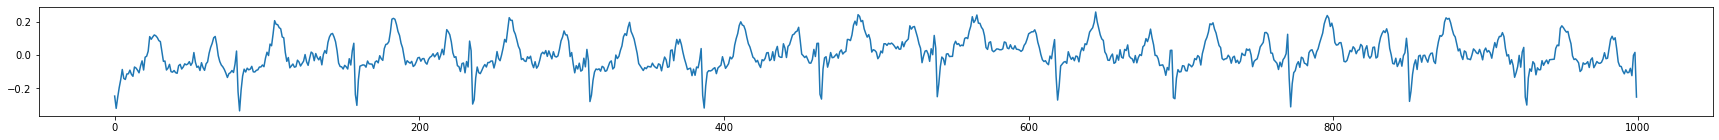

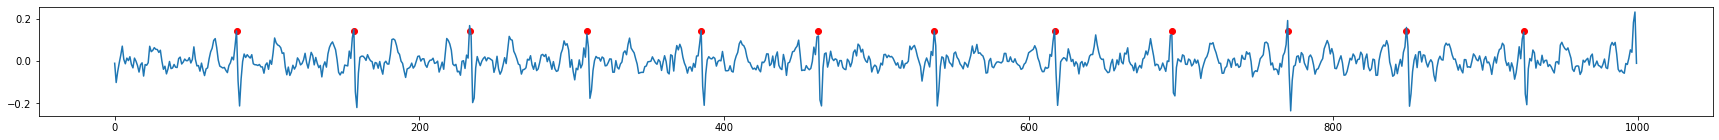

In [15]:
checkBioSPPYOutput(67,1)

### __Noisy ECG__ (Data itself)

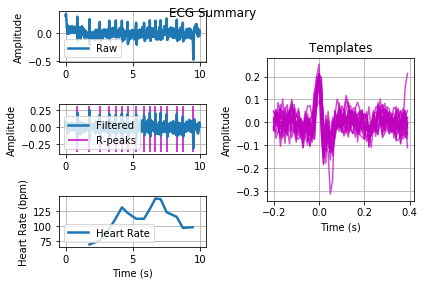

Rpeaks
[ 87 178 255 325 374 420 463 526 585 628 670 709 753 829 875 948]
heart rate
[ 69.93006993  76.52347652  95.36178108 112.86601597 130.80621531
 121.73592052 112.15596474 112.15596474 128.02898061 145.41272681
 144.35564436 123.05238621 115.2485958   97.19131062  98.27278142]
ReturnTuple(rpeaks=array([ 87, 178, 255, 325, 374, 419, 463, 526, 585, 628, 670, 709, 753,
       829, 874, 960]))


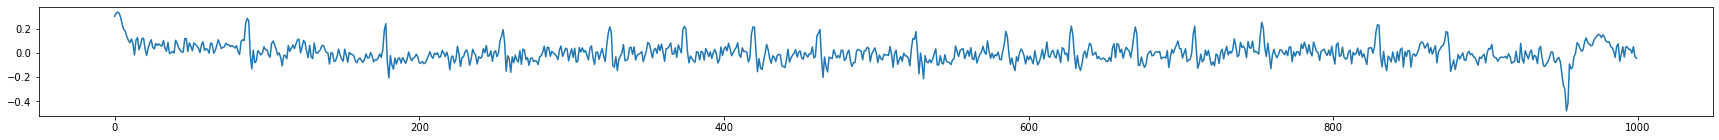

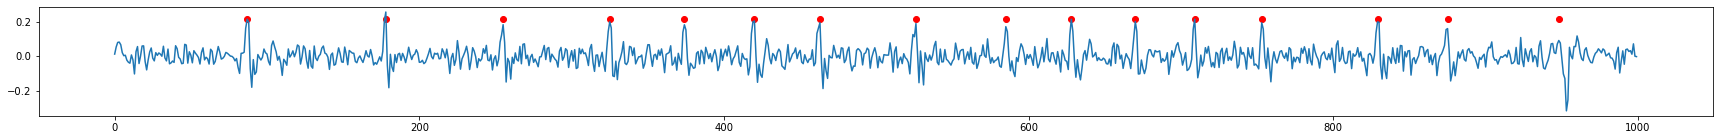

In [16]:
checkBioSPPYOutput(422,1)

### __Abnormal ECG__ (Large T curve)

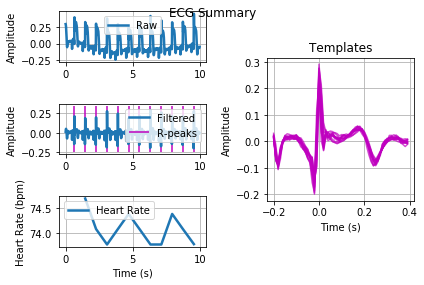

Rpeaks
[ 66 146 227 309 390 470 551 633 714 795 875 957]
heart rate
[74.69135802 74.08160193 73.77295995 74.08160193 74.38271605 74.08160193
 73.77295995 73.77295995 74.38271605 74.08160193 73.7804878 ]
ReturnTuple(rpeaks=array([ 66, 146, 227, 309, 390, 470, 551, 633, 714, 795, 875, 957]))


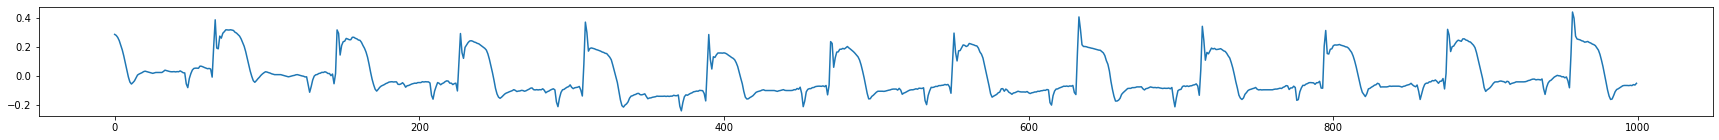

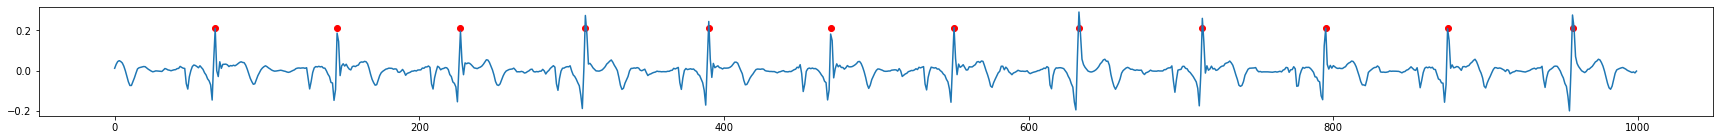

In [17]:
checkBioSPPYOutput(534,1)

### __Abnormal ECG__ (Peak size (amplitude and duration) are irregular) 

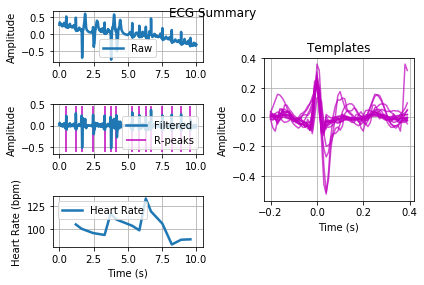

Rpeaks
[ 50 120 162 246 330 374 416 532 584 631 669 752 821 889 957]
heart rate
[104.76190476 100.          95.23809524  93.07359307 116.88311688
 110.31497238 103.32196539  98.25610926 133.6463089  119.28115598
 105.71347174  82.49365749  87.80903666  88.23529412]
ReturnTuple(rpeaks=array([120, 162, 330, 385, 532, 584, 631, 669, 752, 821, 889, 957]))


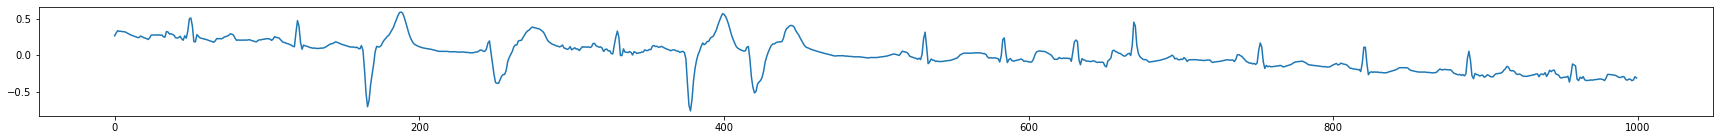

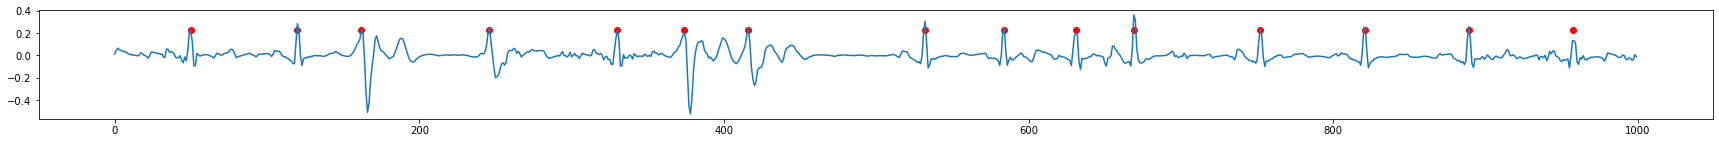

In [18]:
checkBioSPPYOutput(574,1)

### __Abnormal ECG__ (Peak size (amplitude and duration) are irregular) 

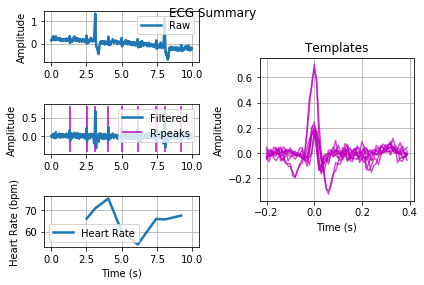

Rpeaks
[132 252 313 406 500 615 746 806 923]
heart rate
[66.12021858 70.95892826 75.56885733 60.17327644 53.93507567 65.99181325
 65.694526   67.52136752]
ReturnTuple(rpeaks=array([252, 313, 406, 500, 615, 746, 806]))


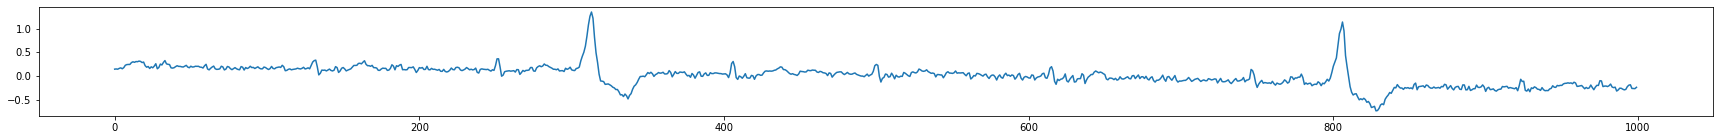

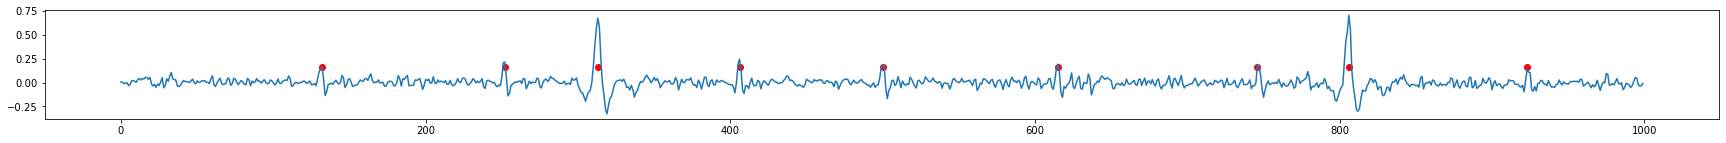

In [19]:
checkBioSPPYOutput(1038,1)

### __ECG with High Heart Rate__

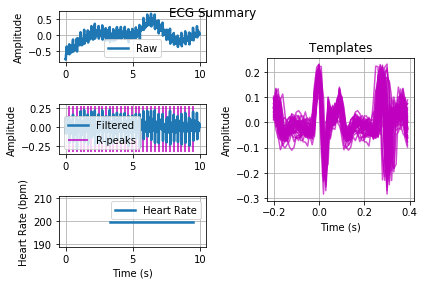

Rpeaks
[ 26  55  83 111 138 165 192 217 246 273 299 329 355 382 412 441 468 497
 524 551 581 609 637 665 693 723 751 779 807 836 864 893 921 951]
heart rate
[200. 200. 200. 200. 200.]
ReturnTuple(rpeaks=array([ 26,  91,  92, 138, 165, 217, 273, 329, 355, 383, 412, 441, 468,
       497, 551, 581, 609, 637, 665, 693, 723, 779, 807, 864, 893, 922,
       950, 980]))


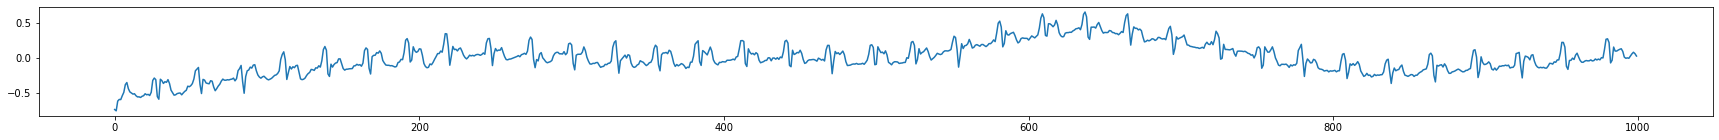

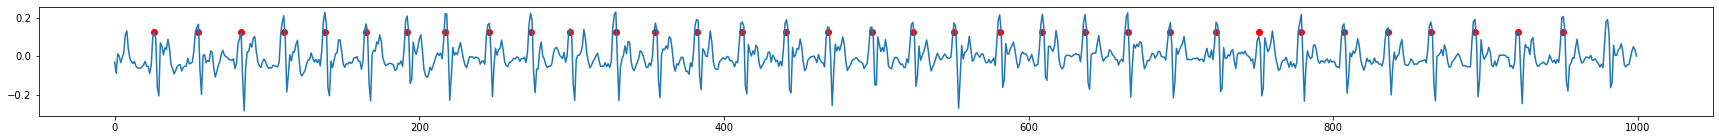

In [20]:
checkBioSPPYOutput(12416,1)

### __ECG with Inverted T Wave__

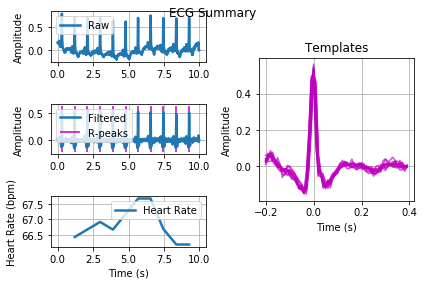

Rpeaks
[ 30 121 210 300 390 480 568 656 746 838 928]
heart rate
[66.42795407 66.67215431 66.91635456 66.66666667 67.17171717 67.67676768
 67.67676768 66.68862538 66.18357488 66.18357488]
ReturnTuple(rpeaks=array([ 30, 121, 210, 300, 390, 480, 568, 656, 746, 838, 928]))


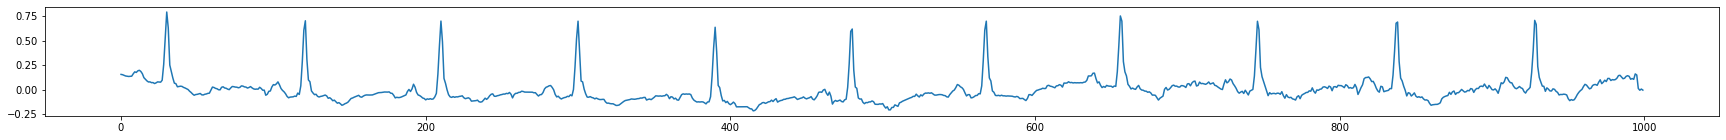

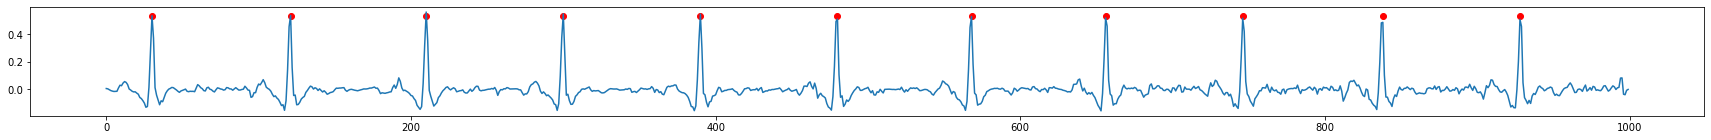

In [11]:
checkBioSPPYOutput(139,1)

# Feature Engineering Continues

## We begin to calculate other clinically relevant features from the ECG data
#### The features we calcualte below require a baseline to be calculated in some cases
#### These clinically relevant features are what a doctor may base their decision on what disease state a patient could have. For example, TR_interval, TR_ratio,PR_interval,PR_ratio, and QR_interval

We present the image of an expected ECG curve again to demonstrate some of the features we will calculate  
(PQRST Complex Wave [5]., n.d.)


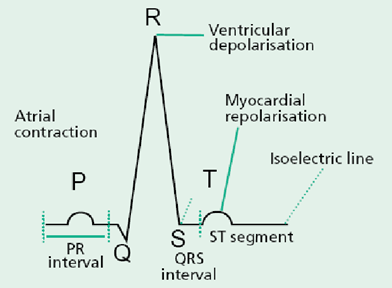

In [21]:
#this is a function to get intervals of an array of integers
def get_int(peaks):
    interval=[]
    for i in range(1, len(peaks)):
        interval.append(peaks[i]-peaks[i-1])
    return(interval)

In [22]:
# this function will locate positions of all R peaks
# default is to use the data from the first lead (lead 11), but will use other leads if the 1st did not pass test

def findindices(ecg_id, lead=11):
    while len(find_peaks(X[ecg_id][:,lead],prominence = 0.1)[0]) < 5:
        lead = (lead - 1)%12
    cutoff=0.7*sorted(find_peaks(X[ecg_id][:,lead],prominence = 0.1)[1]['prominences'])[-5]
    indices=find_peaks(X[ecg_id][:,lead],prominence = cutoff)[0]
    usedlead=lead
    while len(indices) < 5:
        lead = (lead - 1)%12
        cutoff=0.7*sorted(find_peaks(X[ecg_id][:,lead],prominence = 0.1)[1]['prominences'])[-5]
        indices=find_peaks(X[ecg_id][:,lead],prominence = cutoff)[0]
        usedlead=lead
    interval=get_int(indices)
    if (max(interval)-min(interval))/np.mean(interval)>1:
        lead = (lead + 1)%12
        while len(find_peaks(X[ecg_id][:,lead],prominence = 0.1)[0]) < 5:
            lead = (lead + 1)%12
        cutoff=0.7*sorted(find_peaks(X[ecg_id][:,lead],prominence = 0.1)[1]['prominences'])[-5]
        indices=find_peaks(X[ecg_id][:,lead],prominence = cutoff)[0]
        usedlead=lead
        while len(indices) < 5:
            lead = (lead + 1)%12
            cutoff=0.7*sorted(find_peaks(X[ecg_id][:,lead],prominence = 0.1)[1]['prominences'])[-5]
            indices=find_peaks(X[ecg_id][:,lead],prominence = cutoff)[0]
            usedlead=lead
    return(indices,usedlead)


In [23]:
#function find_bpm: input is a list of peaks
#return three values, heart beats per minute (bpm), heart beats irregularity factors (bif and bif2)
#bif is expressed as the relative interval difference of (max-min)/mean
#bif2 is the fraction of the standard deviation of intervals over the mean
def find_bpm(peak_idx):
    interval=get_int(peak_idx)
    bpm=6000/np.mean(interval)
    bif=(max(interval)-min(interval))/np.mean(interval)
    bif2=np.std(interval)/np.mean(interval)
    return(bpm,bif,bif2)


In [24]:
#baseline correction routine, set p=0.05 for positive peaks, p=0.95 for negative peaks
#input y is an array of waveform, and output a baseline-corrected version of y
def baseline_als(y, lam=100, p=0.05, niter=10):
    L = len(y)
    D = sparse.csc_matrix(np.diff(np.eye(L), 2))
    w = np.ones(L)
    for i in range(niter):
        W = sparse.spdiags(w, 0, L, L)
        Z = W + lam * D.dot(D.transpose())
        z = spsolve(Z, w*y)
        w = p * (y > z) + (1-p) * (y < z)
    return(y-z)

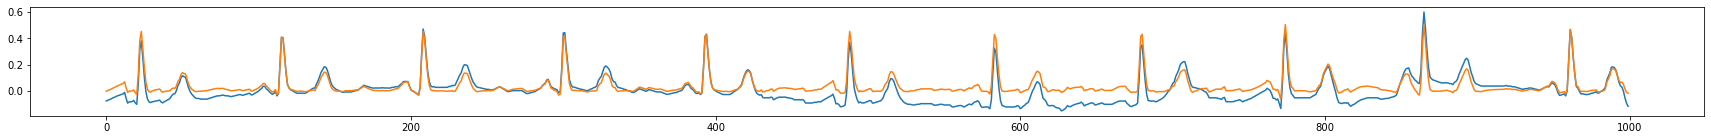

In [25]:
#demonstrate baseline-corrected vs un-corrected waveforms

plot_testX = range(0,1000)
corrected=baseline_als(X[0][:,11])
plt.figure(figsize=(30,2))
plt.plot(plot_testX, X[0][:,11])
plt.plot(plot_testX, corrected)

In [26]:
find_peaks(X[0][:,11],prominence = 0.4)[0]

array([ 23, 115, 208, 301, 394, 488, 583, 680, 774, 865, 961])

In [27]:
#demo of PQRS complex analysis
demo_trace=corrected
demo_index=find_peaks(demo_trace,prominence = 0.4)[0]
seglists=np.split(demo_trace,demo_index)[1:-1]

TR_interval=[]
TR_ratio=[]
PR_interval=[]
PR_ratio=[]
QR_interval=[]

for i in seglists:
    peak_pos=find_peaks(i,width=4)
    peak_neg=find_peaks(-i,width=4)
    cutoff=sorted(peak_pos[1]['prominences'])[-1]
    peak_pos2=find_peaks(i,prominence=cutoff)[0]
    T_idx=peak_pos2[0]
    P_idx=peak_pos[0][-1]
    Q_idx=peak_neg[0][-1]
    TR_interval.append(10*T_idx)
    TR_ratio.append(i[T_idx]/i[0])
    PR_interval.append(10*(len(i)-P_idx+1))
    PR_ratio.append(i[P_idx]/i[0])
    QR_interval.append(10*(len(i)-Q_idx+1))

TRinterval=np.mean(TR_interval)
TRratio=np.mean(TR_ratio)
PRinterval=np.mean(PR_interval)
PRratio=np.mean(PR_ratio)
QRinterval=np.mean(QR_interval)

In [28]:
print(TRinterval)
print(TRratio)
print(PRinterval)
print(PRratio)
print(QRinterval)

275.0
0.3387740368525439
124.0
0.1554638800538188
48.0


Text(0.5, 0, 'time in ms')

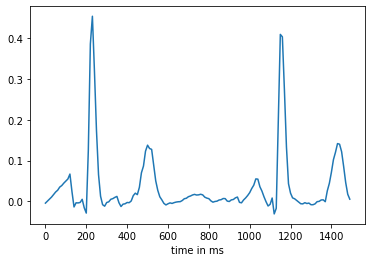

In [29]:
Xrange=[10*i for i in range(150)]
plt.plot(Xrange, corrected[0:150])
plt.xlabel("time in ms")

In [30]:
#function PQRS, input is the trace, and the index list of R
#output 5 features: TRinterval, TRratio, PRinterval, PRratio, QRinterval

def PQRS(trace, index):
    seglists=np.split(trace,index)[1:-1]

    TR_interval=[]
    TR_ratio=[]
    PR_interval=[]
    PR_ratio=[]
    QR_interval=[]

    for i in seglists:
        peak_pos=find_peaks(i,width=4)
        peak_neg=find_peaks(-i,width=4)
        if len(peak_pos[0]) == 0:
            continue
        if len(peak_neg[0]) == 0:
            continue
        cutoff=sorted(peak_pos[1]['prominences'])[-1]
        peak_pos2=find_peaks(i,prominence=cutoff)[0]
        T_idx=peak_pos2[0]
        P_idx=peak_pos[0][-1]
        Q_idx=peak_neg[0][-1]
        TR_interval.append(10*T_idx)
        TR_ratio.append(i[T_idx]/i[0])
        PR_interval.append(10*(len(i)-P_idx+1))
        PR_ratio.append(i[P_idx]/i[0])
        QR_interval.append(10*(len(i)-Q_idx+1))

    TRinterval=np.mean(TR_interval)
    TRratio=np.mean(TR_ratio)
    PRinterval=np.mean(PR_interval)
    PRratio=np.mean(PR_ratio)
    QRinterval=np.mean(QR_interval)
    
    return(TRinterval, TRratio, PRinterval, PRratio, QRinterval)
    
        

## Now that we have created our functions, we apply them to the data

In [40]:
#this is the block calculate bpm, bif, and bif2 values for all ecg's. 
## Note: this next section can take 25 minutes to run
indiceslist=[]
bpmlist=[]
biflist=[]
bif2list=[]
PQRScomplex=[]
TRinterval=[]
TRratio=[]
PRinterval=[]
PRratio=[]
QRinterval=[]

RPeakIndices = []
RPeakIndicesChristov = []
HeartRate = []


for i in range(len(X)):
    indices=findindices(i)
    signal = getPlotableMeasurements(i, 1)
    out = ecg.ecg(signal=signal, sampling_rate=100, show=False)
    # rpeaks
    RPeakIndices = out[2]
    #heart rate
    HeartRate = out[6]
    # returns R peak indices
    RPeakIndicesChristov = biosppy.signals.ecg.christov_segmenter(signal=signal,sampling_rate=100)
#     indiceslist.append(indices[0])
    indiceslist.append(RPeakIndices)
#     lead=indices[1]
    lead = 1
    trace=baseline_als(X[i][:,lead])
#     PQRScomplex.append(PQRS(trace,indices[0]))
    PQRScomplex.append(PQRS(trace,RPeakIndices))                       

In [52]:
# PQRScomplex
# indiceslist
# bpmlocated=find_bpm(indiceslist[0])

In [53]:
for i in range(len(X)):
    bpmlocated=find_bpm(indiceslist[i])
    bpmlist.append(bpmlocated[0])
    biflist.append(bpmlocated[1])
    bif2list.append(bpmlocated[2])
    TRinterval.append(PQRScomplex[i][0])
    TRratio.append(PQRScomplex[i][1])
    PRinterval.append(PQRScomplex[i][2])
    PRratio.append(PQRScomplex[i][3])
    QRinterval.append(PQRScomplex[i][4])

We should be able to use these 8 features for training now

In [54]:
#summary of bpm values
pd.DataFrame(bpmlist).describe()

,0
count,21837.000000
mean,74.228779
std,17.337964
min,21.857923
25%,62.717770
50%,71.174377
75%,82.379863
max,214.054054


### We can "spot check" the outcomes. Below, we view the highest recorded heart rate to make sure that is has been calculated correctly

In [55]:
#ecg_id of 12416 is the highest 
for i in range(len(bpmlist)):
    if bpmlist[i]>200:
        print(i)

12416
21005


In [56]:
# this is the R-peak list for the ecg with the highest bpm:
indiceslist[12416]

array([ 26,  55,  83, 111, 138, 165, 192, 217, 246, 273, 299, 329, 355,
       382, 412, 441, 468, 497, 524, 551, 581, 609, 637, 665, 693, 723,
       751, 779, 807, 836, 864, 893, 921, 951])

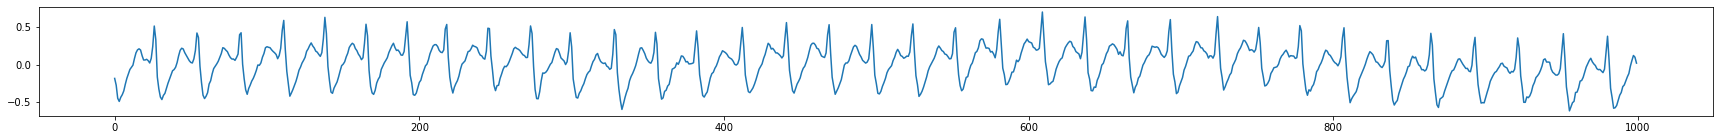

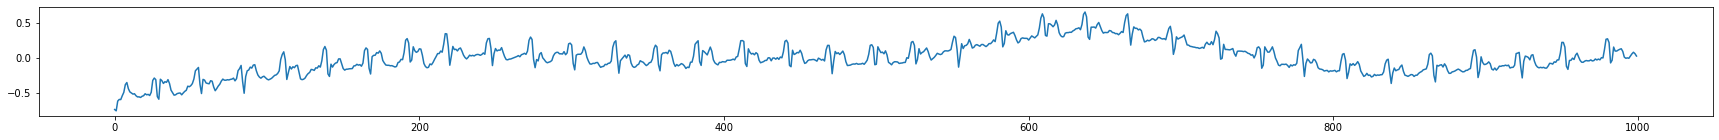

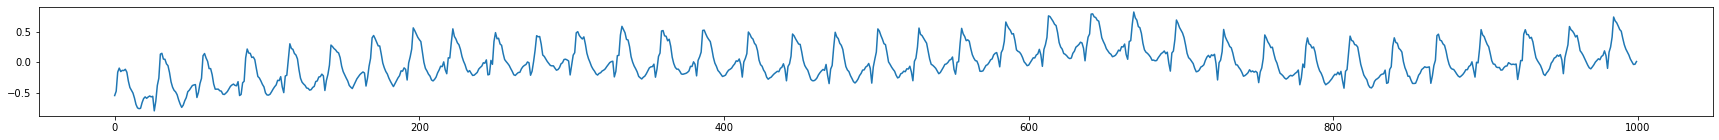

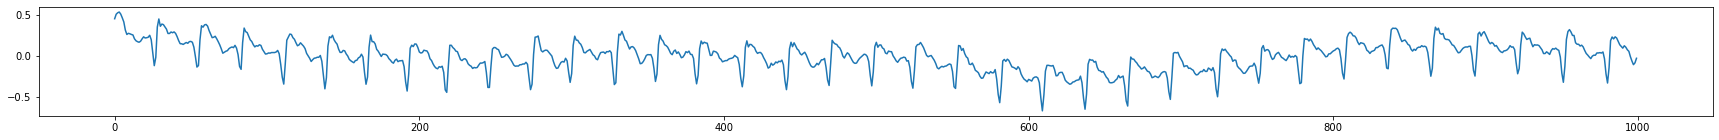

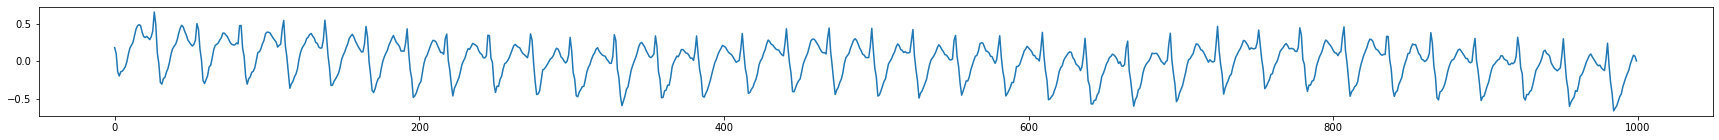

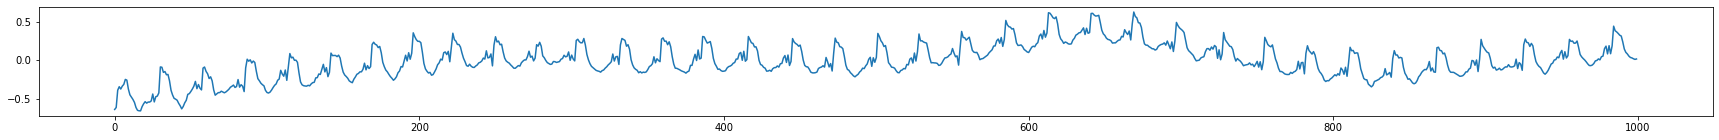

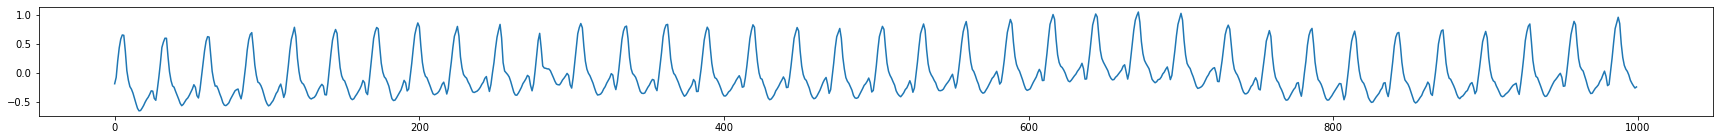

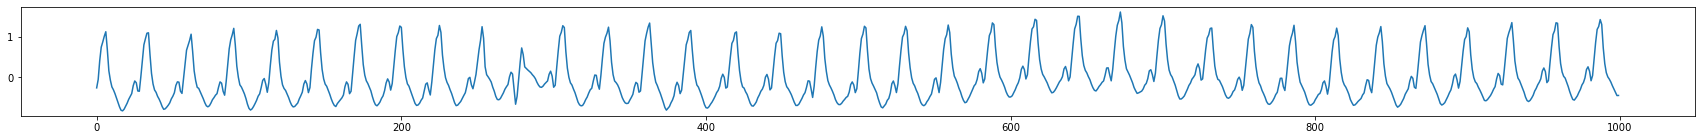

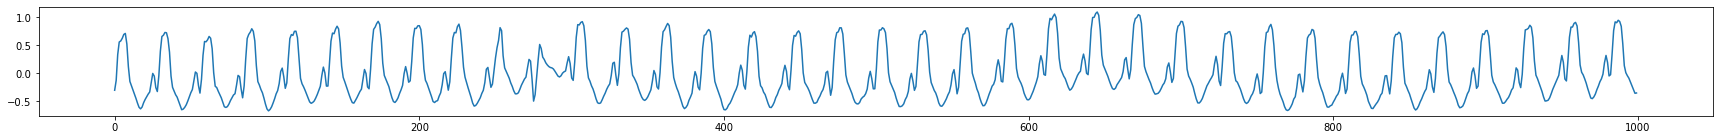

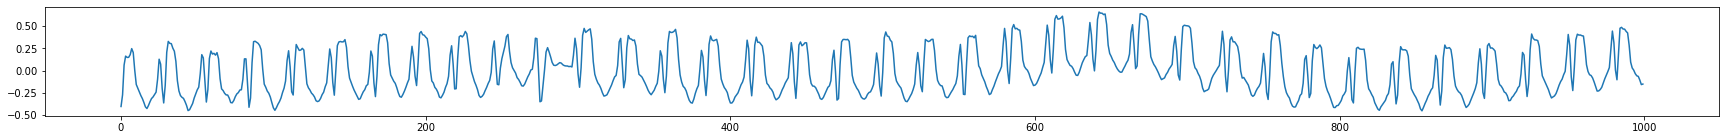

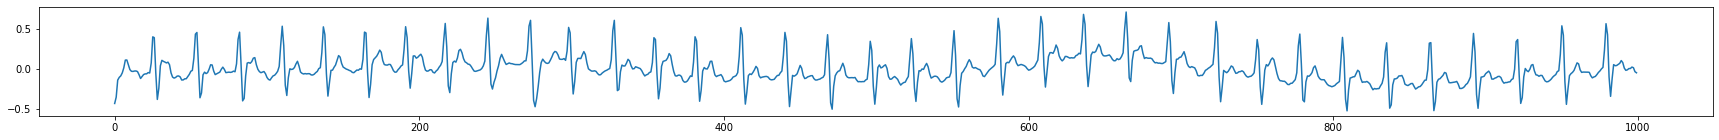

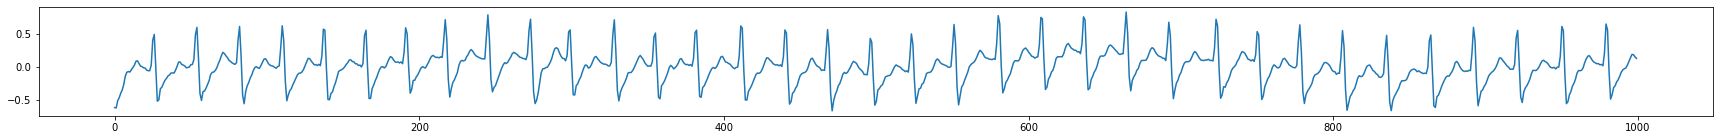

In [57]:
#this is to display ecg_id at 12416 , all 12 leads

import matplotlib.pyplot as plt 

plot_testX = range(0,1000)

for i in range(12):
    plt.figure(figsize=(30,2))
    plt.plot(plot_testX, X[12416][:,i])


## With confidence that we have calculated the most important feature appropriately, we can add these features to our metadata

In [58]:
agg_df = pd.read_csv(path+'scp_statements.csv', index_col=0)
agg_df = agg_df[agg_df.diagnostic == 1]

In [59]:
agg_df.head()

,description,diagnostic,form,rhythm,diagnostic_class,diagnostic_subclass,Statement Category,SCP-ECG Statement Description,AHA code,aECG REFID,CDISC Code,DICOM Code
NDT,non-diagnostic T abnormalities,1.0,1.0,NaN,STTC,STTC,other ST-T descriptive statements,non-diagnostic T abnormalities,NaN,NaN,NaN,NaN
NST_,non-specific ST changes,1.0,1.0,NaN,STTC,NST_,Basic roots for coding ST-T changes and abnorm...,non-specific ST changes,145.0,MDC_ECG_RHY_STHILOST,NaN,NaN
DIG,digitalis-effect,1.0,1.0,NaN,STTC,STTC,other ST-T descriptive statements,suggests digitalis-effect,205.0,NaN,NaN,NaN
LNGQT,long QT-interval,1.0,1.0,NaN,STTC,STTC,other ST-T descriptive statements,long QT-interval,148.0,NaN,NaN,NaN
NORM,normal ECG,1.0,NaN,NaN,NORM,NORM,Normal/abnormal,normal ECG,1.0,NaN,NaN,F-000B7


In [60]:
#this function will return a dictionary {'class-1':likelihood-1, 'class-2':likelihood-2....}

def aggregate_diagnostic(y_dic):
    tmp = {}
    for key in y_dic.keys():
        if key in agg_df.index:
            sctemp=agg_df.loc[key].diagnostic_class
            if sctemp not in list(tmp):
                tmp[sctemp] = y_dic[key]
            else:
                tempval=max(tmp[sctemp], y_dic[key])
                tmp[sctemp] = tempval
    return tmp


In [61]:
#Y.head(20)

In [62]:
Y['diagnostic_superclass'] = Y.scp_codes.apply(aggregate_diagnostic)

In [63]:
#this will expand the superclass dictionary into 5 columns
#each column name is a superclass, and the entry is its corresponding likelihood 
Y=pd.concat([Y,Y['diagnostic_superclass'].apply(pd.Series)],axis=1)

In [64]:
Y.head()

,patient_id,age,sex,height,weight,nurse,site,device,recording_date,report,...,pacemaker,strat_fold,filename_lr,filename_hr,diagnostic_superclass,NORM,MI,STTC,HYP,CD
ecg_id,,,,,,,,,,,,,,,,,,,,,
1,15709.0,56.0,1,NaN,63.0,2.0,0.0,CS-12 E,1984-11-09 09:17:34,sinusrhythmus periphere niederspannung,...,NaN,3,records100/00000/00001_lr,records500/00000/00001_hr,{'NORM': 100.0},100.0,NaN,NaN,NaN,NaN
2,13243.0,19.0,0,NaN,70.0,2.0,0.0,CS-12 E,1984-11-14 12:55:37,sinusbradykardie sonst normales ekg,...,NaN,2,records100/00000/00002_lr,records500/00000/00002_hr,{'NORM': 80.0},80.0,NaN,NaN,NaN,NaN
3,20372.0,37.0,1,NaN,69.0,2.0,0.0,CS-12 E,1984-11-15 12:49:10,sinusrhythmus normales ekg,...,NaN,5,records100/00000/00003_lr,records500/00000/00003_hr,{'NORM': 100.0},100.0,NaN,NaN,NaN,NaN
4,17014.0,24.0,0,NaN,82.0,2.0,0.0,CS-12 E,1984-11-15 13:44:57,sinusrhythmus normales ekg,...,NaN,3,records100/00000/00004_lr,records500/00000/00004_hr,{'NORM': 100.0},100.0,NaN,NaN,NaN,NaN
5,17448.0,19.0,1,NaN,70.0,2.0,0.0,CS-12 E,1984-11-17 10:43:15,sinusrhythmus normales ekg,...,NaN,4,records100/00000/00005_lr,records500/00000/00005_hr,{'NORM': 100.0},100.0,NaN,NaN,NaN,NaN


In [65]:
#add features into our Y table

Y['bpm']=pd.Series(bpmlist)
Y['bif']=pd.Series(biflist)
Y['bif2']=pd.Series(bif2list)
Y['TRinterval']=pd.Series(TRinterval)
Y['TRratio']=pd.Series(TRratio)
Y['PRinterval']=pd.Series(PRinterval)
Y['PRratio']=pd.Series(PRratio)
Y['QRinterval']=pd.Series(QRinterval)

In [66]:
Y.head()

,patient_id,age,sex,height,weight,nurse,site,device,recording_date,report,...,HYP,CD,bpm,bif,bif2,TRinterval,TRratio,PRinterval,PRratio,QRinterval
ecg_id,,,,,,,,,,,,,,,,,,,,,
1,15709.0,56.0,1,NaN,63.0,2.0,0.0,CS-12 E,1984-11-09 09:17:34,sinusrhythmus periphere niederspannung,...,NaN,NaN,47.244094,0.165354,0.058572,285.000000,0.223295,151.666667,0.108760,45.000000
2,13243.0,19.0,0,NaN,70.0,2.0,0.0,CS-12 E,1984-11-14 12:55:37,sinusbradykardie sonst normales ekg,...,NaN,NaN,63.754427,0.074380,0.022088,478.888889,0.229073,168.888889,0.171192,61.111111
3,20372.0,37.0,1,NaN,69.0,2.0,0.0,CS-12 E,1984-11-15 12:49:10,sinusrhythmus normales ekg,...,NaN,NaN,74.408117,0.148816,0.045572,231.818182,0.259358,204.545455,0.097076,75.454545
4,17014.0,24.0,0,NaN,82.0,2.0,0.0,CS-12 E,1984-11-15 13:44:57,sinusrhythmus normales ekg,...,NaN,NaN,66.298343,0.165746,0.054189,267.000000,0.216401,138.000000,0.106722,47.000000
5,17448.0,19.0,1,NaN,70.0,2.0,0.0,CS-12 E,1984-11-17 10:43:15,sinusrhythmus normales ekg,...,NaN,NaN,83.140878,0.152425,0.049263,568.333333,0.151252,163.333333,0.151252,74.166667


In [67]:
#save Y as a CSV, save us time when training models
Y.to_csv('ECG_features.csv')

## This is a checkpoint, from here we can import the data from a previous save (rather than having to rerun everything)

In [8]:
Y = pd.read_csv('ECG_features.csv', index_col='ecg_id')

In [9]:
#Resetting the index so we can include the ecg_id column when converting to a Spark datafram
Y.reset_index(drop=False, inplace=True)
Y.index += 1

In [10]:
Y.head()
len(Y.columns)

42

## Checking that the data loaded as expected

In [11]:
Y.head()

,ecg_id,patient_id,age,sex,height,weight,nurse,site,device,recording_date,...,HYP,CD,bpm,bif,bif2,TRinterval,TRratio,PRinterval,PRratio,QRinterval
1,1,15709.0,56.0,1,NaN,63.0,2.0,0.0,CS-12 E,1984-11-09 09:17:34,...,NaN,NaN,47.244094,0.165354,0.058572,285.000000,0.223295,151.666667,0.108760,45.000000
2,2,13243.0,19.0,0,NaN,70.0,2.0,0.0,CS-12 E,1984-11-14 12:55:37,...,NaN,NaN,63.754427,0.074380,0.022088,478.888889,0.229073,168.888889,0.171192,61.111111
3,3,20372.0,37.0,1,NaN,69.0,2.0,0.0,CS-12 E,1984-11-15 12:49:10,...,NaN,NaN,74.408117,0.148816,0.045572,231.818182,0.259358,204.545455,0.097076,75.454545
4,4,17014.0,24.0,0,NaN,82.0,2.0,0.0,CS-12 E,1984-11-15 13:44:57,...,NaN,NaN,66.298343,0.165746,0.054189,267.000000,0.216401,138.000000,0.106722,47.000000
5,5,17448.0,19.0,1,NaN,70.0,2.0,0.0,CS-12 E,1984-11-17 10:43:15,...,NaN,NaN,83.140878,0.152425,0.049263,568.333333,0.151252,163.333333,0.151252,74.166667


## We convert the disease states to categorical (0 if no percentage, 1 if any percentage)


In [12]:
Y = Y.replace(float("nan"), 0)

In [13]:
Y['NORM'] = Y['NORM'].astype(bool).astype(int)
Y['STTC'] = Y['STTC'].astype(bool).astype(int)
Y['MI'] = Y['MI'].astype(bool).astype(int)
Y['HYP'] = Y['HYP'].astype(bool).astype(int)
Y['CD'] = Y['CD'].astype(bool).astype(int)

In [14]:
Y.head(200)

,ecg_id,patient_id,age,sex,height,weight,nurse,site,device,recording_date,...,HYP,CD,bpm,bif,bif2,TRinterval,TRratio,PRinterval,PRratio,QRinterval
1,1,15709.0,56.0,1,0.0,63.0,2.0,0.0,CS-12 E,1984-11-09 09:17:34,...,0,0,47.244094,0.165354,0.058572,285.000000,0.223295,151.666667,0.108760,45.000000
2,2,13243.0,19.0,0,0.0,70.0,2.0,0.0,CS-12 E,1984-11-14 12:55:37,...,0,0,63.754427,0.074380,0.022088,478.888889,0.229073,168.888889,0.171192,61.111111
3,3,20372.0,37.0,1,0.0,69.0,2.0,0.0,CS-12 E,1984-11-15 12:49:10,...,0,0,74.408117,0.148816,0.045572,231.818182,0.259358,204.545455,0.097076,75.454545
4,4,17014.0,24.0,0,0.0,82.0,2.0,0.0,CS-12 E,1984-11-15 13:44:57,...,0,0,66.298343,0.165746,0.054189,267.000000,0.216401,138.000000,0.106722,47.000000
5,5,17448.0,19.0,1,0.0,70.0,2.0,0.0,CS-12 E,1984-11-17 10:43:15,...,0,0,83.140878,0.152425,0.049263,568.333333,0.151252,163.333333,0.151252,74.166667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
196,196,9374.0,45.0,1,0.0,64.0,0.0,0.0,CS-12 E,1986-03-29 12:28:49,...,0,0,64.056940,0.106762,0.038658,254.444444,0.289652,142.222222,0.131113,57.777778
197,197,14891.0,53.0,0,0.0,88.0,2.0,0.0,CS-12 E,1986-04-04 10:22:28,...,0,0,67.643743,0.124014,0.037747,264.000000,0.186567,158.000000,0.088985,46.000000
198,198,21074.0,19.0,1,0.0,59.0,0.0,0.0,CS-12 E,1986-04-18 10:52:02,...,0,0,97.109827,0.145665,0.041118,472.142857,0.354984,155.714286,0.354984,85.000000
199,199,10746.0,19.0,1,0.0,60.0,0.0,0.0,CS-12 E,1986-04-19 11:20:33,...,1,0,72.115385,0.072115,0.024515,274.000000,0.159250,121.000000,0.052251,48.000000


## We now transition to using Spark

Creating key Spark objects

In [15]:
#converting to Spark df
from pyspark.sql import SparkSession
from pyspark import SQLContext
import os

spark = SparkSession.builder \
        .master("local") \
        .appName("mllib_classifier") \
        .getOrCreate()
sc = spark.sparkContext

sql = SQLContext(sc)

Here we create the schema for our data in order to use it as a dataframe in Spark

In [16]:
# spark_df = sql.createDataFrame(Y)
from pyspark.sql.types import *
mySchema = StructType([ 
    StructField("ecg_id", IntegerType(), True)\
    ,StructField("patient_id", FloatType(), True)\
    ,StructField("age", FloatType(), True)\
    ,StructField("sex", IntegerType(), True)\
    ,StructField("height", FloatType(), True)\
    ,StructField("weight", FloatType(), True)\
    ,StructField("nurse", FloatType(), True)\
    ,StructField("site", StringType(), True)\
    ,StructField("device", StringType(), True)\
    ,StructField("recording_date", StringType(), True)\
    ,StructField("report", StringType(), True)\
    ,StructField("scp_codes", StringType(), True)\
    ,StructField("heart_axis", StringType(), True)\
    ,StructField("infarction_stadium1", StringType(), True)\
    ,StructField("infarction_stadium2", StringType(), True)\
    ,StructField("validated_by", FloatType(), True)\
    ,StructField("second_opinion", StringType(), True)\
    ,StructField("initial_autogenerated_report", StringType(), True)\
    ,StructField("validated_by_human", StringType(), True)\
    ,StructField("baseline_drift", StringType(), True)\
    ,StructField("static_noise", StringType(), True)\
    ,StructField("burst_noise", StringType(), True)\
    ,StructField("electrodes_problems", StringType(), True)\
    ,StructField("extra_beats", StringType(), True)\
    ,StructField("pacemaker", StringType(), True)\
    ,StructField("strat_fold", StringType(), True)\
    ,StructField("filename_lr", StringType(), True)\
    ,StructField("filename_hr", StringType(), True)\
    ,StructField("diagnostic_superclass", StringType(), True)\
    ,StructField("NORM", IntegerType(), True)\
    ,StructField("MI", IntegerType(), True)\
    ,StructField("STTC", IntegerType(), True)\
    ,StructField("HYP", IntegerType(), True)\
    ,StructField("CD", IntegerType(), True)\
    ,StructField("bpm", FloatType(), True)\
    ,StructField("bif", FloatType(), True)\
    ,StructField("bif2", FloatType(), True)\
    ,StructField("TRinterval", FloatType(), True)\
    ,StructField("TRratio", FloatType(), True)\
    ,StructField("PRinterval", FloatType(), True)\
    ,StructField("PRratio", FloatType(), True)\
    ,StructField("QRinterval", FloatType(), True)\
])



We perform the conversion and create the spark dataframe

In [17]:
df = spark.createDataFrame(Y,schema=mySchema)

In [18]:
df.show(1)

+------+----------+----+---+------+------+-----+----+---------+-------------------+--------------------+--------------------+----------+-------------------+-------------------+------------+--------------+----------------------------+------------------+--------------+------------+-----------+-------------------+-----------+---------+----------+--------------------+--------------------+---------------------+----+---+----+---+---+---------+----------+-----------+----------+----------+----------+----------+----------+
|ecg_id|patient_id| age|sex|height|weight|nurse|site|   device|     recording_date|              report|           scp_codes|heart_axis|infarction_stadium1|infarction_stadium2|validated_by|second_opinion|initial_autogenerated_report|validated_by_human|baseline_drift|static_noise|burst_noise|electrodes_problems|extra_beats|pacemaker|strat_fold|         filename_lr|         filename_hr|diagnostic_superclass|NORM| MI|STTC|HYP| CD|      bpm|       bif|       bif2|TRinterval|   TR

# Checking the data for duplicates

In [19]:
#To check how many rows are duplicates
print('Count of rows: {0}'.format(df.count()))
print('Count of distinct rows: {0}'.format(df.distinct().count()))

Count of rows: 21837
Count of distinct rows: 21837


In [20]:
#Then to drop duplicates (note necessary since there are no duplicates)
df = df.dropDuplicates()

In [21]:
#To look if columns other than the id column are duplicates
print('Count of ids: {0}'.format(df.count()))
print('Count of distinct ids: {0}'.format(
    df.select([
       c for c in df.columns if c != 'id'
    ]).distinct().count())
)

Count of ids: 21837
Count of distinct ids: 21837


In [22]:
# And then drop (Again, not necessary)
df = df.dropDuplicates(subset=[
    c for c in df.columns if c != 'id'
])

# Checking the data for numeric outliers

Code taken from StackOVerflow: https://stackoverflow.com/questions/52633916/outlier-detection-in-pyspark

In [31]:
outlierDF = df["age","sex", "height", "weight", "bpm", "bif", "bif2", "TRinterval", "TRratio", "PRinterval", "PRratio", "QRinterval"]
# outlierDF.show()

In [32]:
bounds = {
    c: dict(
        zip(["q1", "q3"], outlierDF["age","sex", "height", "weight", "bpm", "bif", "bif2", "TRinterval", "TRratio", "PRinterval", "PRratio", "QRinterval"].approxQuantile(c, [0.25, 0.75], 0))
    )
    for c in outlierDF.columns
}

In [33]:
for c in bounds:
    iqr = bounds[c]['q3'] - bounds[c]['q1']
    bounds[c]['lower'] = bounds[c]['q1'] - (iqr * 1.5)
    bounds[c]['upper'] = bounds[c]['q3'] + (iqr * 1.5)
print(bounds)

{'age': {'q1': 50.0, 'q3': 72.0, 'lower': 17.0, 'upper': 105.0}, 'sex': {'q1': 0.0, 'q3': 1.0, 'lower': -1.5, 'upper': 2.5}, 'height': {'q1': 0.0, 'q3': 159.0, 'lower': -238.5, 'upper': 397.5}, 'weight': {'q1': 0.0, 'q3': 67.0, 'lower': -100.5, 'upper': 167.5}, 'bpm': {'q1': 62.717769622802734, 'q3': 82.3798599243164, 'lower': 33.22463417053223, 'upper': 111.87299537658691}, 'bif': {'q1': 0.04477611929178238, 'q3': 0.18171021342277527, 'lower': -0.16062502190470695, 'upper': 0.3871113546192646}, 'bif2': {'q1': 0.014052446000277996, 'q3': 0.05674144625663757, 'lower': -0.04998105438426137, 'upper': 0.12077494664117694}, 'TRinterval': {'q1': 228.46153259277344, 'q3': 426.0, 'lower': -67.8461685180664, 'upper': 722.3077011108398}, 'TRratio': {'q1': 0.16795465350151062, 'q3': 0.33380040526390076, 'lower': -0.08081397414207458, 'upper': 0.582569032907486}, 'PRinterval': {'q1': 149.0, 'q3': 209.0, 'lower': 59.0, 'upper': 299.0}, 'PRratio': {'q1': 0.0983748808503151, 'q3': 0.2169322669506073,

In [39]:
import pyspark.sql.functions as f
outlierDFCalculated = outlierDF.select(
    "*",
    *[
        f.when(
            f.col(c).between(bounds[c]['lower'], bounds[c]['upper']),
            0
        ).otherwise(1).alias(c+"_out") 
        for c in outlierDF.columns
    ]
)
outlierDFCalculated.show(5)

+----+---+------+------+---------+-----------+-----------+----------+----------+----------+-----------+----------+-------+-------+----------+----------+-------+-------+--------+--------------+-----------+--------------+-----------+--------------+
| age|sex|height|weight|      bpm|        bif|       bif2|TRinterval|   TRratio|PRinterval|    PRratio|QRinterval|age_out|sex_out|height_out|weight_out|bpm_out|bif_out|bif2_out|TRinterval_out|TRratio_out|PRinterval_out|PRratio_out|QRinterval_out|
+----+---+------+------+---------+-----------+-----------+----------+----------+----------+-----------+----------+-------+-------+----------+----------+-------+-------+--------+--------------+-----------+--------------+-----------+--------------+
|55.0|  0|   0.0|  83.0|58.252426|  0.2524272| 0.07200193|     277.5|0.25282234|     157.5|0.069910124|     66.25|      0|      0|         0|         0|      0|      0|       0|             0|          0|             0|          0|             0|
|24.0|  1|  

In [65]:
age_out = outlierDFCalculated.where(outlierDFCalculated.age_out == 1).count()

In [66]:
height_out = outlierDFCalculated.where(outlierDFCalculated.height_out == 1).count()

In [67]:
weight_out = outlierDFCalculated.where(outlierDFCalculated.weight_out == 1).count()

In [68]:
bpm_out = outlierDFCalculated.where(outlierDFCalculated.bpm_out == 1).count()

In [69]:
bif_out = outlierDFCalculated.where(outlierDFCalculated.bif_out == 1).count()

In [70]:
bif2_out = outlierDFCalculated.where(outlierDFCalculated.bif2_out == 1).count()

In [71]:
TRinterval_out = outlierDFCalculated.where(outlierDFCalculated.TRinterval_out == 1).count()

In [72]:
TRratio_out = outlierDFCalculated.where(outlierDFCalculated.TRratio_out == 1).count()

In [73]:
PRinterval_out = outlierDFCalculated.where(outlierDFCalculated.PRinterval_out == 1).count()

In [74]:
PRratio_out = outlierDFCalculated.where(outlierDFCalculated.PRratio_out == 1).count()

In [75]:
QRinterval_out = outlierDFCalculated.where(outlierDFCalculated.QRinterval_out == 1).count()

In [80]:
outliersDisplay = spark.createDataFrame(
    [
        (age_out, age_out), # create your data here, be consistent in the types.
        (height_out, height_out),
        (weight_out, weight_out),
        (bpm_out, bpm_out),
        (bif_out, bif_out),
        (bif2_out, bif2_out),
        (TRinterval_out, TRinterval_out),
        (TRratio_out, TRratio_out),
        (PRinterval_out, PRinterval_out),
        (PRratio_out, PRratio_out),
        (QRinterval_out, QRinterval_out),
    ],
    ['id', 'number of outliers'] # add your columns label here
)
outliersDisplay.show()

+----+------------------+
|  id|number of outliers|
+----+------------------+
| 181|               181|
|   0|                 0|
|  15|                15|
| 741|               741|
|3531|              3531|
|3282|              3282|
|1342|              1342|
|1527|              1527|
|2121|              2121|
|1316|              1316|
|1337|              1337|
+----+------------------+



# Descriptive Statistics

### __Note__ that here we include some deliverables from the promt, namely
Number of records  
Number of columns  
Statistical summary of response variable  
Statistical summary of potential predictor variables (if there are a large number of predictors, select the top 10)  
Note: Summarize categorical variables with counts and percentages for each level and summarize numerical variables with mean/quantiles/standard deviation.  

### __Number of Records__

In [23]:
numRecords = df.count()

print("The number of records is: "+ str(numRecords))
print("This matches manually checking the excel file")

# X.view()
print("The number of records of ECG data is " + str(len(X)))
print("Which matches the number of records from teh demographics data: " + str(len(Y)))

The number of records is: 21837
This matches manually checking the excel file
The number of records of ECG data is 21837
Which matches the number of records from teh demographics data: 21837


In [24]:
for record in range(0,len(X)):
    if len(X[record]) != 1000:
        print("there was a record that didn't have exactly 1000 observations")
print("Each record had exactly " + str(len(X[1])) +" observations")


Each record had exactly 1000 observations


In [25]:
for record in range(0,len(X)):
    if len(X[record]) != 1000:
        print("there was a record that didn't have exactly 1000 observations")
print("Each observation had exactly " + str(len(X[1][1])) +" measurements (for the 12 leads)")


Each observation had exactly 12 measurements (for the 12 leads)


### __Number of Columns__

In [26]:
numColumns = len(df.columns)

print("The number of columns is: "+ str(numColumns))
print("This matches manually checking the excel file (plus the response variable columns we added)")

The number of columns is: 42
This matches manually checking the excel file (plus the response variable columns we added)


### __Statistical summary of response variable__

In [86]:
#this block no longer makes sense, since now this column is a dictionary
#I can switch it back in if necessary
classcount=df.groupby('diagnostic_superclass').count()

In [87]:
classcount.count()

336

In [88]:
#these numbers match the numbers on the physionet website 
print('counts of NORM: ', df.filter(df['NORM']!=0).count())
print('counts of MI: ', df.filter(df['MI']!=0).count())
print('counts of STTC: ', df.filter(df['STTC']!=0).count())
print('counts of CD: ', df.filter(df['CD']!=0).count())
print('counts of HYP: ', df.filter(df['HYP']!=0).count())

counts of NORM:  9528
counts of MI:  5486
counts of STTC:  5123
counts of CD:  4907
counts of HYP:  2655


In [89]:
df.groupby('strat_fold').count().show()

+----------+-----+
|strat_fold|count|
+----------+-----+
|         7| 2178|
|         3| 2194|
|         8| 2179|
|         5| 2176|
|         6| 2178|
|         9| 2193|
|         1| 2177|
|        10| 2203|
|         4| 2175|
|         2| 2184|
+----------+-----+



In [90]:
type(df)

pyspark.sql.dataframe.DataFrame

## __Histogram Visualizations__

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f9fa741d310>]],
      dtype=object)

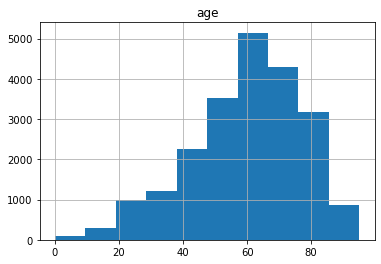

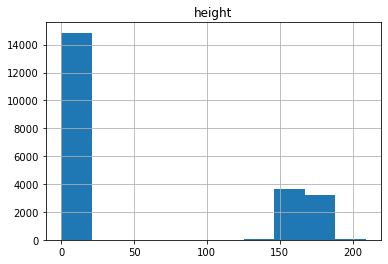

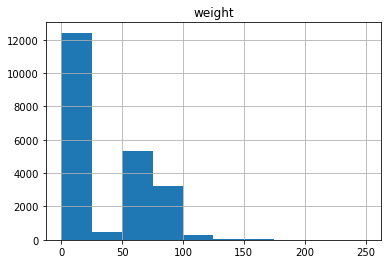

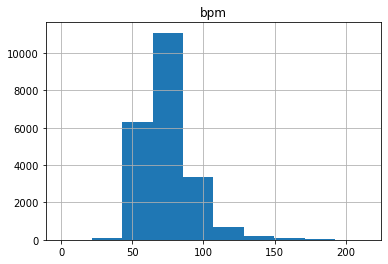

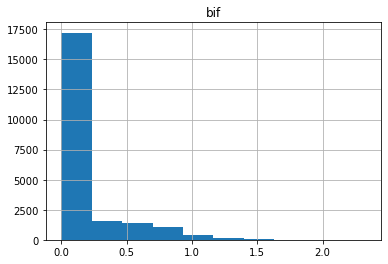

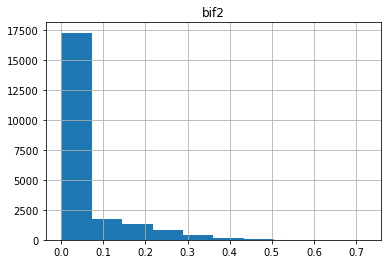

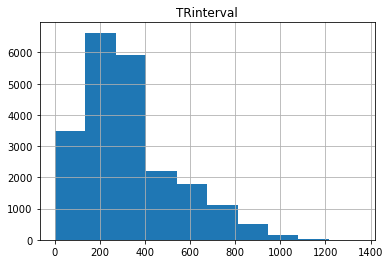

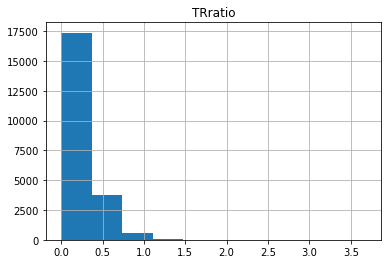

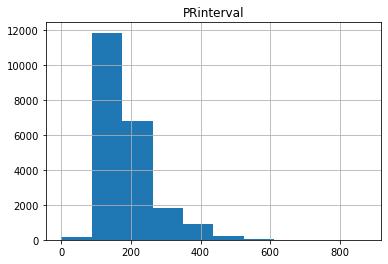

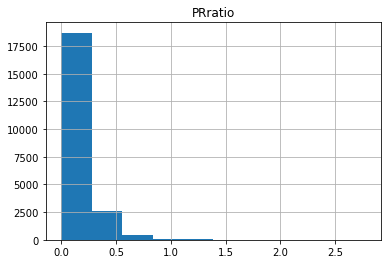

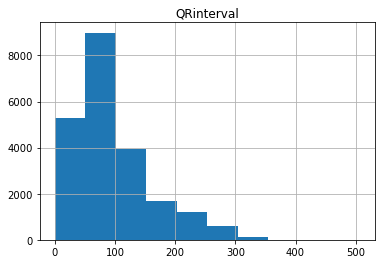

In [95]:
Y.hist(column='age')
Y.hist(column='height')
Y.hist(column='weight')
Y.hist(column='bpm')
Y.hist(column='bif')
Y.hist(column='bif2')
Y.hist(column='TRinterval')
Y.hist(column='TRratio')
Y.hist(column='PRinterval')
Y.hist(column='PRratio')
Y.hist(column='QRinterval')

In [96]:
devicecount=df.groupby('device').count()
devicecount.show()

+----------+-----+
|    device|count|
+----------+-----+
|AT-6 C 5.0|   80|
|AT-60    3|  966|
|AT-6 C 5.5| 3952|
|    AT-6 C|  542|
|AT-6     6| 2273|
|AT-6 C 5.8|  824|
|AT-6 C 5.3|   67|
|     CS-12| 4048|
| CS-12   E| 2886|
|AT-6 C 5.6|   59|
|CS100    3| 6140|
+----------+-----+



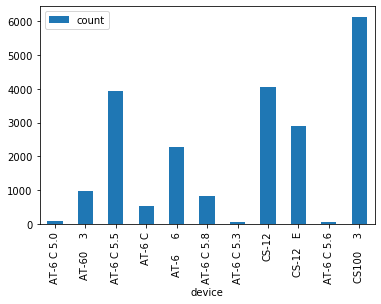

In [97]:
dfDevice = devicecount.toPandas()

ax = dfDevice.plot.bar(x='device', y='count', rot=90)

## We keep the variables we will use in the model

In [98]:
# retain these predictors for Part 1
vars_to_keep = ["diagnostic_superclass","age","sex", "bpm", "bif", "bif2", "TRinterval", "TRratio","PRinterval","PRratio","QRinterval","NORM", "MI","STTC","HYP","CD",
               "strat_fold"]

# subset the dataframe on these predictors
df2 = df[vars_to_keep]
df2.show()

+---------------------+----+---+---------+-----------+------------+----------+-----------+----------+-----------+----------+----+---+----+---+---+----------+
|diagnostic_superclass| age|sex|      bpm|        bif|        bif2|TRinterval|    TRratio|PRinterval|    PRratio|QRinterval|NORM| MI|STTC|HYP| CD|strat_fold|
+---------------------+----+---+---------+-----------+------------+----------+-----------+----------+-----------+----------+----+---+----+---+---+----------+
|      {'NORM': 100.0}|55.0|  0|58.252426|  0.2524272|  0.07200193|     277.5| 0.25282234|     157.5|0.069910124|     66.25|   1|  0|   0|  0|  0|         1|
|      {'NORM': 100.0}|24.0|  1| 72.55139| 0.26602176|  0.06022931|      58.0|  0.4006193|     223.0| 0.12773602|     211.0|   1|  0|   0|  0|  0|         3|
|      {'NORM': 100.0}|28.0|  0|  56.6706|  0.0377804| 0.013717769|     417.5| 0.13754088|    138.75| 0.13276179|      90.0|   1|  0|   0|  0|  0|         9|
|      {'NORM': 100.0}|63.0|  1| 73.00885|0.06084070

## Now we create a feature vector

In [17]:
from pyspark.ml.linalg import DenseVector

In [18]:
#Vector Assembler is a useful function for this, 
# here is a useful tutorial: https://spark.apache.org/docs/latest/ml-features#vectorassembler

from pyspark.ml.feature import VectorAssembler
from pyspark.ml.linalg import Vectors

assembler = VectorAssembler(
    inputCols=["age","sex", "bpm", "bif", "bif2", "TRinterval", "TRratio","PRinterval","PRratio","QRinterval"],
    outputCol="features")

df2 = assembler.transform(df2)
df2.show()

+---------------------+----+---+---------+-----------+-----------+----------+-----------+----------+------------+----------+----+---+----+---+---+----------+--------------------+
|diagnostic_superclass| age|sex|      bpm|        bif|       bif2|TRinterval|    TRratio|PRinterval|     PRratio|QRinterval|NORM| MI|STTC|HYP| CD|strat_fold|            features|
+---------------------+----+---+---------+-----------+-----------+----------+-----------+----------+------------+----------+----+---+----+---+---+----------+--------------------+
|      {'NORM': 100.0}|56.0|  1|46.979866| 0.16442953| 0.05657346|     280.0| 0.19629309|     150.0|  0.04754031|  41.42857|   1|  0|   0|  0|  0|         3|[56.0,1.0,46.9798...|
|       {'NORM': 80.0}|19.0|  0|63.559322|0.074152544|0.022818495|     301.0| 0.13447043|     160.0|  0.07334481|      53.0|   1|  0|   0|  0|  0|         2|[19.0,0.0,63.5593...|
|      {'NORM': 100.0}|37.0|  1| 75.07821| 0.20020854|0.053200837|     227.5| 0.23357421| 211.66667|  0.0

## __Correlation Visualization__

In [117]:
dfnumeric = df["age","sex", "height", "weight", "bpm", "bif", "bif2", "TRinterval", "TRratio", "PRinterval", "PRratio", "QRinterval"]
n_numerical = 12
cols = ["age","sex", "height", "weight", "bpm", "bif", "bif2", "TRinterval", "TRratio", "PRinterval", "PRratio", "QRinterval"]
corr = []

for i in range(0, n_numerical):
    temp = [None] * i
    
    for j in range(i, n_numerical):
        temp.append(dfnumeric.corr(cols[i],cols[j]))
    corr.append(temp)

In [119]:
type(corr)

list

In [133]:
column_names = ["age","sex", "height", "weight", "bpm", "bif", "bif2", "TRinterval", "TRratio", "PRinterval", "PRratio", "QRinterval"]
correlation = pd.DataFrame(corr, index=column_names, columns=column_names)

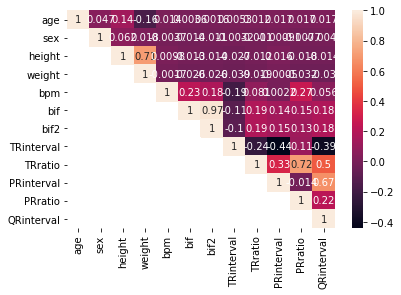

In [134]:
import seaborn as sns
%matplotlib inline
sns.heatmap(correlation, annot=True)

In [126]:
correlation.columns

Index(['age', 'sex', 'height', 'weight', 'bpm', 'bif', 'bif2', 'TRinterval',
       'TRratio', 'PRinterval', 'PRratio', 'QRinterval'],
      dtype='object')

## Here we scale the feature vector

In [19]:
# load modules
import pandas as pd
import pyspark.sql.functions as F
import pyspark.mllib.regression as reg
from pyspark.mllib.classification import LogisticRegressionWithLBFGS
from pyspark.mllib.evaluation import BinaryClassificationMetrics
from pyspark.mllib.regression import LabeledPoint

In [20]:
# Feature scaling
from pyspark.ml.feature import StandardScaler

# Initialize the `standardScaler`
standardScaler = StandardScaler(inputCol="features", outputCol="features_scaled", 
                                withStd=True, withMean=False)

# Fit the DataFrame to the scaler; this computes the mean, standard deviation of each feature
scaler = standardScaler.fit(df2)

# Transform the data in `df2` with the scaler
scaled_df = scaler.transform(df2)

scaled_df.show()

+---------------------+----+---+---------+-----------+-----------+----------+-----------+----------+------------+----------+----+---+----+---+---+----------+--------------------+--------------------+
|diagnostic_superclass| age|sex|      bpm|        bif|       bif2|TRinterval|    TRratio|PRinterval|     PRratio|QRinterval|NORM| MI|STTC|HYP| CD|strat_fold|            features|     features_scaled|
+---------------------+----+---+---------+-----------+-----------+----------+-----------+----------+------------+----------+----+---+----+---+---+----------+--------------------+--------------------+
|      {'NORM': 100.0}|56.0|  1|46.979866| 0.16442953| 0.05657346|     280.0| 0.19629309|     150.0|  0.04754031|  41.42857|   1|  0|   0|  0|  0|         3|[56.0,1.0,46.9798...|[3.22901707019790...|
|       {'NORM': 80.0}|19.0|  0|63.559322|0.074152544|0.022818495|     301.0| 0.13447043|     160.0|  0.07334481|      53.0|   1|  0|   0|  0|  0|         2|[19.0,0.0,63.5593...|[1.09555936310286...|


## Here we split into the Test and Train Data as specified in the documentation

In [21]:
# according to the documentation, we should reserve "strat_fold"'s #9 and #10 for testing
seed = 314
train_data = scaled_df[scaled_df.strat_fold < 9]
test_data = scaled_df[scaled_df.strat_fold > 8]


## Here we perform some initial Model Exploration

We initially find that the models targeting a specific disease state do not perform well (value of 0 for precision and accuracy) so we decide to target noraml vs not normal (next section)

In [22]:
from pyspark.ml.classification import LogisticRegression
maxIter=10
regParam=0.3
elasticNetParam=0.8

In [23]:
# function to calucalte the accuracy, precision, recall, adn fmeasure
def sum_col(df, col): 
    return df.select(F.sum(col)).collect()[0][0]

def getpredictions(model, test_dat, column):
    predictions = model.transform(test_dat)
    predictions = predictions.withColumn('TP', F.when((F.col(column) == 1) & (F.col("prediction")==1), 1).otherwise(0))
    predictions = predictions.withColumn('TN', F.when((F.col(column) == 0) & (F.col("prediction")==0), 1).otherwise(0))
    predictions = predictions.withColumn('FP', F.when((F.col(column) == 0) & (F.col("prediction")==1), 1).otherwise(0))
    predictions = predictions.withColumn('FN', F.when((F.col(column) == 1) & (F.col("prediction")==0), 1).otherwise(0))
    accuracy = (sum_col(predictions, "TP")+sum_col(predictions, "TN"))/predictions.count()
    if (sum_col(predictions, "TP")+sum_col(predictions, "FP"))>0:
        precision = sum_col(predictions, "TP")/(sum_col(predictions, "TP")+sum_col(predictions, "FP"))
    else:
        precision = "Precision could not be calculated due to a lack of TP/FP values"
    if (sum_col(predictions, "TP")+sum_col(predictions, "FN"))>0:
        recall = sum_col(predictions, "TP")/(sum_col(predictions, "TP")+sum_col(predictions, "FN"))
    else:
        precision = "Recall could not be calculated due to a lack of TP/FN values"
    if ((2*sum_col(predictions, "TP")+sum_col(predictions, "FP")+sum_col(predictions, "FN")))>0:
        fmeasure = (2*sum_col(predictions, "TP"))/(2*sum_col(predictions, "TP")+sum_col(predictions, "FP")+sum_col(predictions, "FN"))
    else:
        fmeasure = "Fmeasure could not be calculated due to a lack of TP/FN/FP values"
    print("accuracy:"+str(accuracy))
    print("precision:"+str(precision))
    print("recall:"+str(recall))
    print("fmeasure:"+str(fmeasure))

### Logistic Regression

In [24]:
lrNORM = LogisticRegression(featuresCol="features_scaled", labelCol="NORM",maxIter=10, regParam=0.1, elasticNetParam=0.8)
modelLR_NORM = lrNORM.fit(train_data)
getpredictions(modelLR_NORM, test_data, "NORM")

accuracy:0.5818926296633303
precision:0.7195767195767195
recall:0.07079646017699115
fmeasure:0.12890995260663507


In [25]:
lrMI = LogisticRegression(featuresCol="features_scaled", labelCol="MI",maxIter=10, regParam=0.3, elasticNetParam=0.8)
modelLR_MI = lrMI.fit(train_data)
getpredictions(modelLR_MI, test_data, "MI")

accuracy:0.7504549590536852
precision:Precision could not be calculated due to a lack of TP/FP values
recall:0.0
fmeasure:0.0


In [26]:
lrHYP = LogisticRegression(featuresCol="features_scaled", labelCol="HYP",maxIter=10, regParam=0.3, elasticNetParam=0.8)
modelLR_HYP = lrHYP.fit(train_data)
getpredictions(modelLR_HYP, test_data, "HYP")

accuracy:0.87852593266606
precision:Precision could not be calculated due to a lack of TP/FP values
recall:0.0
fmeasure:0.0


In [27]:
lrSTTC = LogisticRegression(featuresCol="features_scaled", labelCol="STTC",maxIter=10, regParam=0.3, elasticNetParam=0.8)
modelLR_STTC = lrSTTC.fit(train_data)
getpredictions(modelLR_STTC, test_data, "STTC")

accuracy:0.7659235668789809
precision:Precision could not be calculated due to a lack of TP/FP values
recall:0.0
fmeasure:0.0


In [28]:
lrCD = LogisticRegression(featuresCol="features_scaled", labelCol="CD",maxIter=10, regParam=0.3, elasticNetParam=0.8)
modelLR_CD = lrCD.fit(train_data)
getpredictions(modelLR_CD, test_data, "CD")

accuracy:0.7736578707916287
precision:Precision could not be calculated due to a lack of TP/FP values
recall:0.0
fmeasure:0.0


### Decision Tree

In [29]:
from pyspark.ml.classification import DecisionTreeClassifier
dt = DecisionTreeClassifier(featuresCol = 'features_scaled', labelCol = 'NORM', maxDepth = 3)
dtModel = dt.fit(train_data)
predictions = dtModel.transform(test_data)
predictions.select("NORM", "prediction").show(10)


+----+----------+
|NORM|prediction|
+----+----------+
|   0|       0.0|
|   1|       0.0|
|   1|       1.0|
|   0|       0.0|
|   0|       0.0|
|   0|       0.0|
|   0|       0.0|
|   0|       0.0|
|   0|       0.0|
|   0|       1.0|
+----+----------+
only showing top 10 rows



In [30]:
lrNORM = DecisionTreeClassifier(featuresCol = 'features_scaled', labelCol = 'NORM', maxDepth = 3)
modelLR_NORM = lrNORM.fit(train_data)
getpredictions(modelLR_NORM, test_data, "NORM")

accuracy:0.6671974522292994
precision:0.7489130434782608
recall:0.3586673607496096
fmeasure:0.4850404787046815


In [31]:
lrMI = DecisionTreeClassifier(featuresCol = 'features_scaled', labelCol = 'MI', maxDepth = 3)
modelLR_MI = lrMI.fit(train_data)
getpredictions(modelLR_MI, test_data, "MI")

accuracy:0.7504549590536852
precision:Precision could not be calculated due to a lack of TP/FP values
recall:0.0
fmeasure:0.0


In [32]:
lrHYP = DecisionTreeClassifier(featuresCol = 'features_scaled', labelCol = 'HYP', maxDepth = 3)
modelLR_HYP = lrHYP.fit(train_data)
getpredictions(modelLR_HYP, test_data, "HYP")

accuracy:0.87852593266606
precision:Precision could not be calculated due to a lack of TP/FP values
recall:0.0
fmeasure:0.0


In [33]:
lrSTTC = DecisionTreeClassifier(featuresCol = 'features_scaled', labelCol = 'STTC', maxDepth = 3)
modelLR_STTC = lrSTTC.fit(train_data)
getpredictions(modelLR_STTC, test_data, "STTC")

accuracy:0.7659235668789809
precision:Precision could not be calculated due to a lack of TP/FP values
recall:0.0
fmeasure:0.0


In [34]:
lrCD = DecisionTreeClassifier(featuresCol = 'features_scaled', labelCol = 'CD', maxDepth = 3)
modelLR_CD = lrCD.fit(train_data)
getpredictions(modelLR_CD, test_data, "CD")

accuracy:0.7736578707916287
precision:Precision could not be calculated due to a lack of TP/FP values
recall:0.0
fmeasure:0.0


# __For Robust Model Building and Pipeline Development, please see the second Jupyter notebook submitted with this report__

# Based on our models' perfromance, we believe that there is further work that can be done. To that end, we began to explore the use of neural networks for this project, though the work performed in this case was strictly exploratory in nature

### Neural Network

In [ ]:
import tensorflow as tf
from pyspark.sql import functions as F

scaled_df2 = scaled_df.withColumn("Target", F.when(col('NORM') == 1, 1).otherwise(0))

target = np.array(scaled_df2.select('Target').collect())

features = np.array(scaled_df2.select('features').collect())

features2 = np.array(scaled_df2.select('features_scaled').collect())

df3 = df[vars_to_keep]

assembler = VectorAssembler(
    inputCols=["bpm", "bif", "bif2", "TRinterval", "TRratio","PRinterval","PRratio","QRinterval"],
    outputCol="features")

df3 = assembler.transform(df3)

standardScaler = StandardScaler(inputCol="features", outputCol="features_scaled", 
                                withStd=True, withMean=False)

# Fit the DataFrame to the scaler; this computes the mean, standard deviation of each feature
scaler = standardScaler.fit(df3)

# Transform the data in `df2` with the scaler
scaled_df3 = scaler.transform(df3)

scaled_df3 = scaled_df3.withColumn("Target", F.when(col('NORM') == 1, 1).otherwise(0))

target3 = np.array(scaled_df3.select('Target').collect())
features3 = np.array(scaled_df3.select('features_scaled').collect())

from tensorflow import keras
from tensorflow.keras import layers

x_train, x_test = features2[0:16000], features2[16000:21837]

x_train2, x_test2 = features[0:16000], features[16000:21837]

y_train, y_test = target[0:16000], target[16000:21837]

x_train3, x_test3 = features3[0:16000], features3[16000:21837]

y_train3, y_test3 = target3[0:16000], target3[16000:21837]

def neural_net(x_train, y_train, x_test, y_test, epochs, batch_size):
    model = tf.keras.models.Sequential([
      tf.keras.layers.Flatten(input_shape=x_train.shape[1:3]),
      tf.keras.layers.Dense(256, activation='relu'),
      tf.keras.layers.Dropout(0.1),
      tf.keras.layers.Dense(256, activation='relu'),
      tf.keras.layers.Dense(10, activation='softmax')
    ])

    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size)

    return model.evaluate(x_test, y_test)

neural_net(x_train, y_train, x_test, y_test, 1000, 256)

neural_net(x_train, y_train, x_test, y_test, 1000, 128)

neural_net(x_train2, y_train, x_test2, y_test, 1000, 256)

neural_net(x_train3, y_train3, x_test3, y_test3, 1000, 128)

x_train4, y_train4 = X[0:16000], target[0:16000]

x_test4, y_test4 = X[16000:21837], target[16000:21837]

neural_net(x_train4, y_train4, x_test4, y_test4, 1000, 128)